# **Simple PyG HGT Model**

In [1]:
# Import Basic Libraries

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)


from scipy import stats


import random

import itertools
from itertools import product

from tqdm.auto import tqdm   # For Visualizing Progress Bars While Code Is Being Executed


from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, brier_score_loss

import logging

from torchmetrics import AUROC, ConfusionMatrix, Precision, Recall, F1Score


# PyTorch Library
# torch_geometric ≡ PyTorch Geormetric (PyG) Library

import torch
from torch_geometric.transforms import ToUndirected
from torch_geometric.loader import DataLoader
from torch_geometric.nn import HGTConv, Linear, global_add_pool, global_mean_pool, global_max_pool
import torch.nn.functional as F



import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

sns.set_style('darkgrid')



# Import the Thesis' Simple HGT Functions Module

import Thesis_Simple_HGT_Model_Functions as TSHGTMFs





%matplotlib inline


___
___
___

## Datasets' Properties

### Training Dataset

In [2]:
# Create Training Graphs Dataset - Using the `ToUndirected` Transform

Training_Simple_Dataset = TSHGTMFs.Soccer_Heterogeneous_Graphs_Dataset( root = ".", training_or_test_data = "training",
                                                                             want_directed_or_undirected_edges = "directed", pre_transform = ToUndirected( merge = False ),
                                                                             simple_or_complex_graphs = "simple", log = True )


print(f"#Graphs In the Original Training Dataset = {len(Training_Simple_Dataset)}", "\n")


#Graphs In the Original Training Dataset = 50000 



### **1st Time Download Run-Time $\approx$ 50mins**

___

### Splitting Training Dataset Into $\rightarrow$ Training + Validation Datasets

#### Set #Splits

In [3]:
# Set #Splits

Num_K_Splits = 5


#### Visualize the CV Split

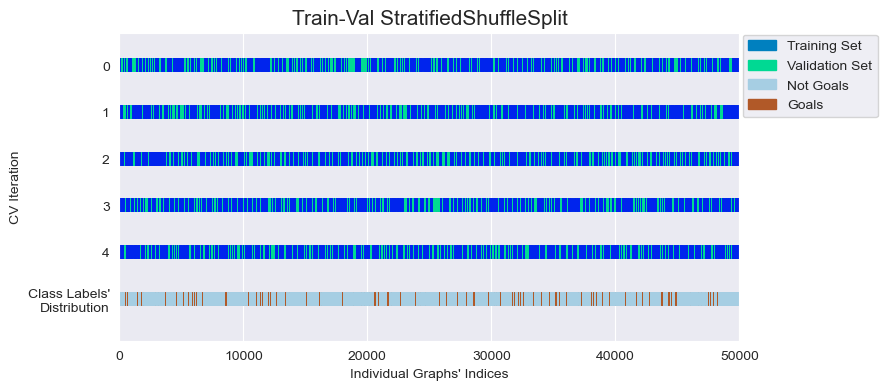

In [4]:
# Visualize the CV Split

CV_Strategy = StratifiedShuffleSplit( n_splits = Num_K_Splits, test_size = 0.3, random_state = 7 )


fig, ax = plt.subplots(figsize = (8, 4))

TSHGTMFs.Plot_CV_Splitted_Indices( PyG_dataset = Training_Simple_Dataset, cv_strategy = CV_Strategy, num_K_splits = Num_K_Splits, figure_axes = ax, lw = 10 );


#### Splitting Training Dataset Into $\rightarrow$ Training + Validation Datasets

In [5]:
# Extracting Class Labels
    
Class_Labels_array = Training_Simple_Dataset._data.y.numpy()

Validation_Size = 0.3


# Stratified Shuffled K Split
    
Stratified_Shuffled_K_Splits_CV = StratifiedShuffleSplit( n_splits = Num_K_Splits, test_size = Validation_Size, random_state = 7 )



___

### Test Dataset

In [6]:
# Create Test Graphs Dataset - Using the `ToUndirected` Transform

Test_Simple_Dataset = TSHGTMFs.Soccer_Heterogeneous_Graphs_Dataset( root = ".", training_or_test_data = "test",
                                                                         want_directed_or_undirected_edges = "directed", pre_transform = ToUndirected( merge = False ),
                                                                         simple_or_complex_graphs = "simple", log = True )


print(f"#Graphs In the Test Dataset = {len(Test_Simple_Dataset)}", '\n')


#Graphs In the Test Dataset = 2416 



### **1st Time Download Run-Time $\approx$ 8mins**

___
___

## Individual Graph's Properties

### Training Dataset

In [7]:
# Extracting the 1st Graph From the Training Dataset

First_Training_Graph = Training_Simple_Dataset[0]

print(First_Training_Graph, '\n')


HeteroData(
  y=[1],
  Ball={
    x=[1, 4],
    pos=[1, 2],
  },
  Player={
    x=[22, 3],
    pos=[22, 2],
  },
  (Ball, Interacts, Player)={
    edge_index=[2, 22],
    edge_attr=[22],
  },
  (Player, Connects, Player)={
    edge_index=[2, 231],
    edge_attr=[231, 2],
  },
  (Player, rev_Interacts, Ball)={
    edge_index=[2, 22],
    edge_attr=[22],
  },
  (Player, rev_Connects, Player)={
    edge_index=[2, 231],
    edge_attr=[231, 2],
  }
) 



In [8]:
First_Training_Graph.is_undirected()

True

In [9]:
First_Training_Graph.validate()

True

In [10]:
First_Training_Graph.metadata()

(['Ball', 'Player'],
 [('Ball', 'Interacts', 'Player'),
  ('Player', 'Connects', 'Player'),
  ('Player', 'rev_Interacts', 'Ball'),
  ('Player', 'rev_Connects', 'Player')])

___
___

## Set Random Seed For Reproducibility

In [11]:

TSHGTMFs.Set_Seed( random_seed = 7 )


___
___

## Defining GNN Model's Architecture

In [ ]:
class HGT_Model_Simple(torch.nn.Module):
    
    def __init__(self, num_HGTConv_layers, hidden_NN_node_units, num_attention_heads, message_aggregation_strategy, dropout_rate, global_graph_pooling_strategy):
        
        super(HGT_Model_Simple, self).__init__()
        
        torch.manual_seed(7)


        self.Output_Hidden_NN_Node_Units = hidden_NN_node_units

        self.Dropout_Rate = dropout_rate   # Store Dropout-Rate As a Class Attribute
        self.Global_Graph_Pooling_Strategy = global_graph_pooling_strategy   # Store Global Graph Pooling Strategy As a Class Attribute

        
        self.HGT_Convs_list = torch.nn.ModuleList()

        for Layer_i in range(num_HGTConv_layers):
            
            Input_Hidden_NN_Node_Units = hidden_NN_node_units if Layer_i > 0 else -1

            HGT_Convolutional_layer = HGTConv( in_channels = Input_Hidden_NN_Node_Units, out_channels = self.Output_Hidden_NN_Node_Units, metadata = First_Training_Graph.metadata(),
                                               heads = num_attention_heads, group = message_aggregation_strategy )

            self.HGT_Convs_list.append(HGT_Convolutional_layer)

        
        
        # Adjusted (i.e. `2 *`) For Combined Features From Nodes & Edges
    
        self.Final_Readout_Linear_Layer = Linear( in_channels = 2 * self.Output_Hidden_NN_Node_Units, out_channels = 1 )   # out_channels = 1  <==>  Because We Are Doing Binary Classification



    
    def forward(self, x_dict, edge_index_dict, ball_batch_index, player_batch_index):

        
        # HGT Convolutional Layers
        
        for HGT_Convolution in self.HGT_Convs_list:
            
            x_dict = HGT_Convolution( x_dict, edge_index_dict )
            
            x_dict = { key : F.relu(x) for key, x in x_dict.items() }
            
            x_dict = { key : F.dropout( x, p = self.Dropout_Rate, training = self.training ) for key, x in x_dict.items() }

        

        # Global Graph Pooling Strategy
        
        Pooling_Function = global_mean_pool if self.Global_Graph_Pooling_Strategy == "mean" else \
                           global_add_pool if self.Global_Graph_Pooling_Strategy == "sum" else \
                           global_max_pool


        
        # Pooling For Both Node Types
        
        Ball_Node_Features_pooling = Pooling_Function( x_dict["Ball"], ball_batch_index )
        
        Player_Node_Features_pooling = Pooling_Function( x_dict["Player"], player_batch_index )


        
        # Combining Node- & Edge-Features
        
        Combined_Node_Features_Embeddings = torch.cat( [Ball_Node_Features_pooling, Player_Node_Features_pooling], dim = 1 )
        

        
        Output = self.Final_Readout_Linear_Layer(Combined_Node_Features_Embeddings)
        

        return Output

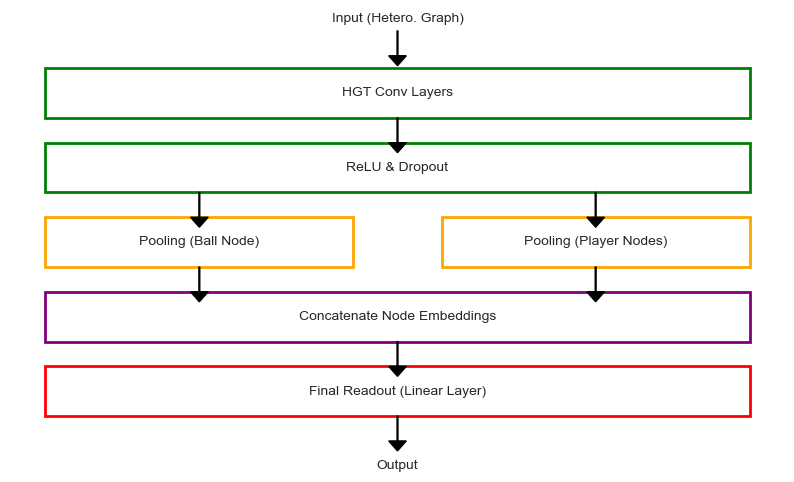

In [27]:
# Creating a Diagram of the HGT Model Architecture


# Recreating the figure with adjusted text and arrow positions

fig, ax = plt.subplots(figsize=(10, 6))

# Increase the vertical position of "Input Hetero. Graph Data" text and arrow
ax.text(0.5, 0.85, "Input (Hetero. Graph)", horizontalalignment='center', verticalalignment='center')
ax.arrow(0.5, 0.825, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')

# HGT Conv Layers box
ax.add_patch(patches.Rectangle((0.1, 0.65), 0.8, 0.1, edgecolor='green', facecolor='none', lw=2))
ax.text(0.5, 0.7, "HGT Conv Layers", horizontalalignment='center', verticalalignment='center')

# ReLU & Dropout box
ax.add_patch(patches.Rectangle((0.1, 0.5), 0.8, 0.1, edgecolor='green', facecolor='none', lw=2))
ax.text(0.5, 0.55, "ReLU & Dropout", horizontalalignment='center', verticalalignment='center')

# Pooling for Ball Node box
ax.add_patch(patches.Rectangle((0.1, 0.35), 0.35, 0.1, edgecolor='orange', facecolor='none', lw=2))
ax.text(0.275, 0.4, "Pooling (Ball Node)", horizontalalignment='center', verticalalignment='center')

# Pooling for Player Nodes box
ax.add_patch(patches.Rectangle((0.55, 0.35), 0.35, 0.1, edgecolor='orange', facecolor='none', lw=2))
ax.text(0.725, 0.4, "Pooling (Player Nodes)", horizontalalignment='center', verticalalignment='center')

# Concatenate Node Embeddings box
ax.add_patch(patches.Rectangle((0.1, 0.2), 0.8, 0.1, edgecolor='purple', facecolor='none', lw=2))
ax.text(0.5, 0.25, "Concatenate Node Embeddings", horizontalalignment='center', verticalalignment='center')

# Final Readout (Linear Layer) box
ax.add_patch(patches.Rectangle((0.1, 0.05), 0.8, 0.1, edgecolor='red', facecolor='none', lw=2))
ax.text(0.5, 0.1, "Final Readout (Linear Layer)", horizontalalignment='center', verticalalignment='center')

# Lower the vertical position of "Output" text and arrow
ax.text(0.5, -0.05, "Output", horizontalalignment='center', verticalalignment='center')
ax.arrow(0.5, 0.05, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')

# Adding arrows
ax.arrow(0.5, 0.65, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.arrow(0.275, 0.5, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.arrow(0.725, 0.5, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.arrow(0.275, 0.35, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.arrow(0.725, 0.35, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.arrow(0.5, 0.2, 0, -0.05, head_width=0.02, head_length=0.02, fc='k', ec='k')

# Setting the axis off
ax.set_axis_off()

# Display the diagram
plt.show()


___
___

## Setting the +ve Class Label's Weight Due To High Class-Imbalance In Data

In [13]:
# Find & Use CUDA (IF Available) or Use the CPU

Device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

print(f"Device To Use ==> {Device}", "\n")



# Compute Class Weights In Accordance To Their Proportion/Distribution Within the Data

y_Class_Labels_For_Full_Training_Dataset_array = Training_Simple_Dataset._data.y.numpy()

Class_Weights = compute_class_weight( "balanced", classes = np.unique(y_Class_Labels_For_Full_Training_Dataset_array), y = y_Class_Labels_For_Full_Training_Dataset_array )


print("In All 3 Datasets (Training, Validation, & Test): \n",
      "Negative Class (0.0 ≡ Non-Scored Shots ≡ Non-Goals) Proportion : Positive Class (1.0 ≡ Scored Shots ≡ Goals) Proportion  -->  9:1", "\n")

print(f"Negative Class (0.0 ≡ Non-Scored Shots ≡ Non-Goals) 'Balanced' Weight : Positive Class (1.0 ≡ Scored Shots ≡ Goals) 'Balanced' Weight --> {Class_Weights}", "\n")



Positive_Class_Weight_tensor = torch.tensor( Class_Weights[1], dtype = torch.float ).to(Device)   # Class_Weights[1] = 4.31629834



Device To Use ==> cpu 

In All 3 Datasets (Training, Validation, & Test): 
 Negative Class (0.0 ≡ Non-Scored Shots ≡ Non-Goals) Proportion : Positive Class (1.0 ≡ Scored Shots ≡ Goals) Proportion  -->  9:1 

Negative Class (0.0 ≡ Non-Scored Shots ≡ Non-Goals) 'Balanced' Weight : Positive Class (1.0 ≡ Scored Shots ≡ Goals) 'Balanced' Weight --> [0.56550851 4.31629834] 



___
___

## Set Hyper-Parameter Space

In [14]:
# Define Hyper-Parameter Space

HyperParameter_Space_dict = { "Positive_Class_Weight" : [Positive_Class_Weight_tensor, None],
                              "Batch_Size" : [512, 1024, 2048],   # [128, 256, 512, 1024, 2048]
                              "Num_HGTConv_Layers" : [1, 2, 3],   # [1, 2, 3]
                              "Hidden_NN_Node_Units" : [16, 32, 64, 128],   # [8, 16, 32, 64, 128]
                              "Num_Attention_Heads" : [1, 2, 4],   # [1, 2, 4]
                              "Message_Aggregation_Strategy" : ["sum", "mean", "max"],   # ["sum", "mean", "max"]
                              "Dropout_Rate" : [0.0, 0.25, 0.5],   # [0.25, 0.5, 0.75]
                              "Global_Graph_Pooling_Strategy" : ["sum", "mean", "max"],   # ["sum", "mean", "max"]
                              "Learning_Rate" : [0.001, 0.0001, 0.00001],   # [0.001, 0.0001, 0.00001]
                              "Weight_Decay" : [0.001, 0.0001] }



# Number of Random Combinations To Try

Num_Random_HP_Combinations = 10


# List of All Hyper-Parameter Combinations

All_HP_Combinations = list( itertools.product( *HyperParameter_Space_dict.values() ) )   # == 768 Possible Combinations


# Generate Random Combinations

random.seed(7)   # Ensure Reproducible Combination/Configuration of Random Selection of Hyper-Parameters


Random_HP_Combinations = random.sample( All_HP_Combinations, Num_Random_HP_Combinations )

print("Randomly Selected Combination/Configuration of Hyper-Parameters:", "\n")


for HP_Combination_ID, HP_Combination in tqdm( enumerate(Random_HP_Combinations), total = Num_Random_HP_Combinations, desc = "Hyper-Parameter Tuning" ):

    print(f"HP Combination #{HP_Combination_ID} = {HP_Combination}")


Randomly Selected Combination/Configuration of Hyper-Parameters: 



Hyper-Parameter Tuning:   0%|          | 0/10 [00:00<?, ?it/s]

HP Combination #0 = (None, 512, 2, 128, 4, 'sum', 0.0, 'sum', 0.001, 0.001)
HP Combination #1 = (tensor(4.3163), 1024, 3, 16, 2, 'sum', 0.0, 'sum', 1e-05, 0.001)
HP Combination #2 = (None, 1024, 2, 32, 1, 'max', 0.0, 'mean', 0.0001, 0.0001)
HP Combination #3 = (tensor(4.3163), 512, 2, 64, 2, 'mean', 0.25, 'max', 0.0001, 0.001)
HP Combination #4 = (tensor(4.3163), 512, 3, 32, 4, 'sum', 0.5, 'max', 0.001, 0.0001)
HP Combination #5 = (tensor(4.3163), 1024, 1, 16, 4, 'sum', 0.0, 'max', 0.001, 0.001)
HP Combination #6 = (None, 1024, 1, 32, 1, 'max', 0.5, 'mean', 0.001, 0.0001)
HP Combination #7 = (tensor(4.3163), 512, 2, 128, 4, 'mean', 0.25, 'sum', 0.0001, 0.0001)
HP Combination #8 = (None, 2048, 3, 16, 2, 'sum', 0.5, 'mean', 0.0001, 0.0001)
HP Combination #9 = (tensor(4.3163), 2048, 2, 16, 4, 'max', 0.25, 'max', 0.001, 0.001)


___
___

## Training & Evaluating GNN Model On Training & Validation Sub-Datasets, Respectively

### Defining the Training Policy On Training Sub-Dataset

In [15]:
def Train_GNN_Model( GNN_model, training_loader, optimizer, criterion ):
    
    GNN_model.train()
    
    Total_Loss = 0

    
    # Initialize AUROC metric
    
    Training_ROC_AUC_Metric = AUROC( task = "binary" )
    
    Training_ROC_AUC_Metric.reset()  # Reset AUROC Metric At the Start of Each Epoch    

    
    for Loader_Batch_Data in training_loader:
        
        optimizer.zero_grad()
        
        Loader_Batch_Data.to(Device)

        Training_Model_Output = GNN_model( x_dict = Loader_Batch_Data.x_dict, edge_index_dict = Loader_Batch_Data.edge_index_dict,
                                           ball_batch_index = Loader_Batch_Data["Ball"].batch, player_batch_index = Loader_Batch_Data["Player"].batch )

        
        Loss = criterion( Training_Model_Output.view(-1), Loader_Batch_Data.y.float() )
        
        Loss.backward()

        torch.nn.utils.clip_grad_norm_( GNN_model.parameters(), max_norm = 5 )   # To Clip the Learning Gradient In the 1st Epoch of Training  --  `max_norm` = 5 Is Conservative
        
        optimizer.step()
                
        Total_Loss += Loss.item()

        
        # Representing the Goal Probability of the Shot
        
        y_Training_Predicted_Positive_Class_Label_Probability = torch.sigmoid( Training_Model_Output.squeeze() )

        
        # Update AUROC For Every Batch
        
        Training_ROC_AUC_Metric.update( y_Training_Predicted_Positive_Class_Label_Probability.detach(),  Loader_Batch_Data.y )


    Training_Loss = Total_Loss / len(training_loader)
    
    
    # Compute AUROC For the Epoch
    
    Training_ROC_AUC_Score = Training_ROC_AUC_Metric.compute()


    
        
    return Training_Loss, Training_ROC_AUC_Score



___

### Defining the Evaluation Policy On Validation Sub-Dataset

In [16]:
def Evaluate_GNN_Model( GNN_model, evaluation_loader, criterion ):
    
    GNN_model.eval()

    Total_Loss = 0


    # Initialize AUROC metric
    
    Validation_ROC_AUC_Metric = AUROC( task = "binary" )
    
    Validation_ROC_AUC_Metric.reset()  # Reset AUROC Metric At the Start of Each Epoch
    

    
    with torch.no_grad():
    
        for Loader_Batch_Data in evaluation_loader:
            
            
            Loader_Batch_Data.to(Device)

            Validation_Model_Output = GNN_model( x_dict = Loader_Batch_Data.x_dict, edge_index_dict = Loader_Batch_Data.edge_index_dict,
                                                 ball_batch_index = Loader_Batch_Data["Ball"].batch, player_batch_index = Loader_Batch_Data["Player"].batch )
            
            Loss = criterion( Validation_Model_Output.view(-1), Loader_Batch_Data.y.float() )
            
            Total_Loss += Loss.item()

        
            # Representing the Goal Probability of the Shot
        
            y_Validation_Predicted_Positive_Class_Label_Probability = torch.sigmoid( Validation_Model_Output.squeeze() )

            
            Validation_ROC_AUC_Metric.update( y_Validation_Predicted_Positive_Class_Label_Probability,  Loader_Batch_Data.y )


    Validation_Loss = Total_Loss / len(evaluation_loader)
    
    
    # Compute AUROC For the Epoch
    
    Validation_ROC_AUC_Score = Validation_ROC_AUC_Metric.compute()

    

    
    return Validation_Loss, Validation_ROC_AUC_Score



___

### Hyper-Parameter Tuning | Stratified Shuffled 5-Fold CV | Training | Validation $\downarrow$

In [17]:
# Initialize the List of Mean Validation ROC AUC Scores Per HP Combination -- 10 HP Combinations

Mean_Validation_ROC_AUC_Scores_Per_HP_Combination_list = []   # Dim = (1, 10)



# Initialize the Dictionary of Histories of Losses & ROC AUC-Scores (Values) Per HP Combination ID (Keys)

HP_Combinations_Performance_and_Histories_dict = {}


In [18]:

# Basic Configuration of the Logging System
logging.basicConfig( filename = "Log of Simple HGT Model -- HP Tuning, CV, Training and Validation.log", level = logging.INFO, format = "%(asctime)s - %(levelname)s - %(message)s" )

Num_Epochs = 50

# Perform Hyper-Parameter Tuning/Optimization (HPT/HPO)
for HP_Combination_ID, HP_Combination in tqdm( enumerate(Random_HP_Combinations), total = Num_Random_HP_Combinations, desc = "Hyper-Parameter Tuning, CV & Training + Validation Pipelines" ):
    
    # Unpack the Hyper-Parameters    
    ( Positive_Class_Weight, Batch_Size, Num_HGTConv_Layers, Hidden_NN_Node_Units, Num_Attention_Heads, Message_Aggregation_Strategy, Dropout_Rate, Global_Graph_Pooling_Strategy, Learning_Rate, Weight_Decay ) = HP_Combination
    HP_Combination_Counter = HP_Combination_ID + 1        
    logging.info(f"HP COMBINATION #{HP_Combination_Counter}  -->  +ve Class Weight = {Positive_Class_Weight} | Batch_Size = {Batch_Size}  |  Num_HGTConv_Layers = {Num_HGTConv_Layers}  |  Hidden_NN_Node_Units = {Hidden_NN_Node_Units}  |  Num_Attention_Heads = {Num_Attention_Heads}  |  Message_Aggregation_Strategy = {Message_Aggregation_Strategy}  |  Dropout_Rate = {Dropout_Rate}  |  Global_Graph_Pooling_Strategy = {Global_Graph_Pooling_Strategy}  |  Learning_Rate = {Learning_Rate}  |  Weight_Decay = {Weight_Decay}")

    # Initialize the Best Validation ROC AUC-Scores of All the Folds For the Current HP Combination    
    Best_Validation_ROC_AUC_Scores_of_All_Folds_For_Current_HP_Combination_list = []

    # Initialize the Training + Validation Histories of Losses & ROC AUC-Scores of All the CV Folds For the Current HP Combination
    Training_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list, Validation_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list = [], []
    Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list, Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list = [], []

    # Perform Stratified Shuffled 5-Fold CV Split
    for Fold_i, (Training_Indices, Validation_Indices) in tqdm( enumerate( Stratified_Shuffled_K_Splits_CV.split( np.zeros( len(Class_Labels_array) ), Class_Labels_array ) ), total = Num_K_Splits,
                                                                desc = f"HP COMBINATION #{HP_Combination_Counter}  -->  Stratified Shuffled {Num_K_Splits}-Fold CV" ):
        Fold_Counter = Fold_i + 1    
        logging.info(f"CV FOLD #{Fold_Counter}")

        # Split the Original Training Dataset Into Training & Validation Sub-Datasets        
        Training_Simple_SubDataset = Training_Simple_Dataset[ Training_Indices ]
        Validation_Simple_SubDataset = Training_Simple_Dataset[ Validation_Indices ]    

        # A Data-Loader Which Merges Data Objects From a `torch_geometric.data.Dataset` or `torch_geometric.data.InMemoryDataset` To a Mini-Batch. Data Objects Can Be Either of Type `Data` or `HeteroData`
        Training_DataLoader = DataLoader( dataset = Training_Simple_SubDataset, batch_size = Batch_Size, shuffle = True )   # Data Re-Shuffled At Every Epoch
        Validation_DataLoader = DataLoader( dataset = Validation_Simple_SubDataset, batch_size = Batch_Size, shuffle = False )   # Data NOT Re-Shuffled At Every Epoch

        # Initialize HGT_Model, Loss Function, & Optimizer With the Current Set of Hyper-Parameters' Combination    
        HGT_Model = HGT_Model_Simple( num_HGTConv_layers = Num_HGTConv_Layers, hidden_NN_node_units = Hidden_NN_Node_Units, num_attention_heads = Num_Attention_Heads,
                                      message_aggregation_strategy = Message_Aggregation_Strategy, dropout_rate = Dropout_Rate, global_graph_pooling_strategy = Global_Graph_Pooling_Strategy ).to(Device)    
    
        Loss_Function = torch.nn.BCEWithLogitsLoss( pos_weight = Positive_Class_Weight )    
        Optimizer = torch.optim.Adam( HGT_Model.parameters(), lr = Learning_Rate, weight_decay = Weight_Decay )

        # Initialize the Best Validation ROC AUC-Score For the Current CV Fold
        Best_Validation_ROC_AUC_Score_For_Current_Fold = 0

        # Initialize the Training + Validation History of Losses & ROC AUC-Scores For the Current CV Fold
        Training_History_of_Losses_For_Current_CV_Fold_list, Validation_History_of_Losses_For_Current_CV_Fold_list = [], []
        Training_History_of_ROC_AUC_Scores_For_Current_CV_Fold_list, Validation_History_of_ROC_AUC_Scores_For_Current_CV_Fold_list = [], []

        # Early-Stopping Parameters    
        ES_Patience = 15   # Number of Epochs To Wait For Improvement In the Validation ROC AUC-Score, After Which Training For That Particular Set of Hyper-Parameters Will Be Stopped    
        ES_Num_Epochs_Without_Improvement = 0   # Track/Count How Many Epochs Passed Without An Improvement Occuring In the Validation ROC AUC-Score

        # Train and Evaluate the Model On the Training & Validation Sub-Datasets    
        for Epoch in tqdm( range(0, Num_Epochs), desc = f"CV FOLD #{Fold_Counter}  -->  Training + Validation Pipelines" ):      
            
            Training_Loss, Training_ROC_AUC_Score = Train_GNN_Model( GNN_model = HGT_Model, training_loader = Training_DataLoader, optimizer = Optimizer, criterion = Loss_Function )    
            Validation_Loss, Validation_ROC_AUC_Score = Evaluate_GNN_Model( GNN_model = HGT_Model, evaluation_loader = Validation_DataLoader, criterion = Loss_Function )
            
            # Place Values From Training + Validation Loop Into the CV Loop            
            Training_History_of_Losses_For_Current_CV_Fold_list.append(Training_Loss)
            Validation_History_of_Losses_For_Current_CV_Fold_list.append(Validation_Loss)        
            Training_History_of_ROC_AUC_Scores_For_Current_CV_Fold_list.append(Training_ROC_AUC_Score)
            Validation_History_of_ROC_AUC_Scores_For_Current_CV_Fold_list.append(Validation_ROC_AUC_Score)

            if Epoch == 0:   # Log Info. Every 1st Epoch        
                logging.info(f"EPOCH #{Epoch+1} | Train Loss = {Training_Loss} | Training ROC AUC-Score = {Training_ROC_AUC_Score} | Validation Loss = {Validation_Loss} | Validation ROC AUC-Score = {Validation_ROC_AUC_Score}")
            
            if (Epoch + 1) % 5 == 0:   # Log Info. Every 5 Epochs        
                logging.info(f"EPOCH #{Epoch+1} | Train Loss = {Training_Loss} | Training ROC AUC-Score = {Training_ROC_AUC_Score} | Validation Loss = {Validation_Loss} | Validation ROC AUC-Score = {Validation_ROC_AUC_Score}")

            # Check If the Current HGT Model Is the Best One
            if Validation_ROC_AUC_Score > Best_Validation_ROC_AUC_Score_For_Current_Fold:   # Update/Improvement Check For New Best Model

                logging.info(f"FOUND NEW BEST MODEL @ EPOCH #{Epoch+1} --> Updating Best Model & Hyper-Parameters")                
                logging.info(f"EPOCH #{Epoch+1} | Train Loss = {Training_Loss} | Training ROC AUC-Score = {Training_ROC_AUC_Score} | Validation Loss = {Validation_Loss} | *** Validation ROC AUC-Score = {Validation_ROC_AUC_Score} ***")            

                # Update the New Best Validation ROC AUC-Score & Save the Current Model's Weights            
                Best_Validation_ROC_AUC_Score_For_Current_Fold = Validation_ROC_AUC_Score
                
                # Reset Early-Stopping Tracker/Counter            
                ES_Num_Epochs_Without_Improvement = 0        
            else:            
                ES_Num_Epochs_Without_Improvement += 1

            # Early-Stopping Check        
            if ES_Num_Epochs_Without_Improvement >= ES_Patience:            
                logging.info(f"Early-Stopping Triggered After Epoch #{Epoch+1}, Due To No Improvement In the Validation ROC AUC-Score")
                break  # Break Out of the Training Loop For Current Set of Hyper-Parameters

        # Place Values From CV Loop Into HP Tuning Loop        
        Best_Validation_ROC_AUC_Scores_of_All_Folds_For_Current_HP_Combination_list.append( Best_Validation_ROC_AUC_Score_For_Current_Fold )
        Training_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list.append( Training_History_of_Losses_For_Current_CV_Fold_list )
        Validation_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list.append( Validation_History_of_Losses_For_Current_CV_Fold_list )
        Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list.append( Training_History_of_ROC_AUC_Scores_For_Current_CV_Fold_list )
        Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list.append( Validation_History_of_ROC_AUC_Scores_For_Current_CV_Fold_list )

    # Calculate Mean Validation ROC AUC-Score Across All CV Folds For Every HP Combination
    Mean_Validation_ROC_AUC_Score_Across_All_CV_Folds_For_Current_HP_Combination = np.mean( Best_Validation_ROC_AUC_Scores_of_All_Folds_For_Current_HP_Combination_list )

    # Placing Values From HP Tuning Loop Into the Initialized Variables Outside of the Entire Loop
    Mean_Validation_ROC_AUC_Scores_Per_HP_Combination_list.append( Mean_Validation_ROC_AUC_Score_Across_All_CV_Folds_For_Current_HP_Combination )
    
    HP_Combinations_Performance_and_Histories_dict[ HP_Combination_ID ] = { "Mean_Validation_ROC_AUC_Score_Across_All_CV_Folds" : Mean_Validation_ROC_AUC_Score_Across_All_CV_Folds_For_Current_HP_Combination,
                                                                            "Best_Validation_ROC_AUC_Scores_of_All_Folds" : Best_Validation_ROC_AUC_Scores_of_All_Folds_For_Current_HP_Combination_list,
                                                                            "Training_Histories_of_Losses_of_All_5_CV_Folds" : Training_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list,
                                                                            "Validation_Histories_of_Losses_of_All_CV_Folds" : Validation_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list,
                                                                            "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" : Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list,
                                                                            "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" : Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list }    
    

Hyper-Parameter Tuning, CV & Training + Validation Pipelines:   0%|          | 0/10 [00:00<?, ?it/s]

HP COMBINATION #1  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #2  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #3  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #4  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #5  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #6  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #7  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #8  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #9  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

HP COMBINATION #10  -->  Stratified Shuffled 5-Fold CV:   0%|          | 0/5 [00:00<?, ?it/s]

CV FOLD #1  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #2  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #3  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #4  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

CV FOLD #5  -->  Training + Validation Pipelines:   0%|          | 0/50 [00:00<?, ?it/s]

### **↑ Run-Time ≈ 45hrs**

___
___

## Model Selection 

In [43]:
def Round_To_3SF( number ):
    
    import math
    
    if number == 0:
        return 0
    else:
        # Determine the order of magnitude of the number
        order_of_magnitude = int(math.floor(math.log10(abs(number))))
        # Calculate the number of decimal places to round to
        decimal_places = 2 - order_of_magnitude
        # Round the number to the calculated number of decimal places
        return round(number, decimal_places)


logging.info(f"===============================================================================================================================================================================================================")
logging.info(f"===============================================================================================================================================================================================================")
logging.info(f"HP Tuning, Training & Validation Processes Are Over !")
logging.info(f"===============================================================================================================================================================================================================")
logging.info(f"Model Selection !  ↓")
logging.info(f"===============================================================================================================================================================================================================")


# List of Mean Validation ROC AUC-Scores Per HP Combination

logging.info(f"List of Mean Validation ROC AUC-Scores Per HP Combination = {Mean_Validation_ROC_AUC_Scores_Per_HP_Combination_list}")
print(f"List of Mean Validation ROC AUC-Scores Per HP Combination = {Mean_Validation_ROC_AUC_Scores_Per_HP_Combination_list}", "\n")


# Find the Best HP Combination Based On the Highest Mean ROC AUC-Score

Best_HP_Combination_index = np.argmax( Mean_Validation_ROC_AUC_Scores_Per_HP_Combination_list )

logging.info(f"Best HP Combination To Use ==> Combination #{Best_HP_Combination_index+1}")
print(f"Best HP Combination To Use ==> Combination #{Best_HP_Combination_index+1}", "\n")

Best_HP_Combination_tuple = Random_HP_Combinations[ Best_HP_Combination_index ]

Best_HPs_dict = { "Positive_Class_Weight" : Best_HP_Combination_tuple[0],
                  "Batch_Size" : Best_HP_Combination_tuple[1],
                  "Num_HGTConv_Layers" : Best_HP_Combination_tuple[2],
                  "Hidden_NN_Node_Units" : Best_HP_Combination_tuple[3],
                  "Num_Attention_Heads" : Best_HP_Combination_tuple[4],
                  "Message_Aggregation_Strategy" : Best_HP_Combination_tuple[5],
                  "Dropout_Rate" : Best_HP_Combination_tuple[6],
                  "Global_Graph_Pooling_Strategy" : Best_HP_Combination_tuple[7],
                  "Learning_Rate" : Best_HP_Combination_tuple[8],
                  "Weight_Decay" : Best_HP_Combination_tuple[9] }

logging.info(f"Dictionary of the Best Hyper-Parameters Combination = {Best_HPs_dict}")
print(f"Dictionary of the Best Hyper-Parameters Combination = {Best_HPs_dict}", "\n")

Best_HP_Combination_Performance_dict = HP_Combinations_Performance_and_Histories_dict[ Best_HP_Combination_index ]

logging.info(f"Dictionary of the Best HP Combination's Performance = {Best_HP_Combination_Performance_dict}")


# Best ROC AUC-Score Produced In Every CV Fold of the Best HP Combination

# HP_Combinations_Performance_and_Histories_dict[ HP_Combination_ID ] = { "Mean_Validation_ROC_AUC_Score_Across_All_CV_Folds" : Mean_Validation_ROC_AUC_Score_Across_All_CV_Folds_For_Current_HP_Combination,
#                                                                         "Best_Validation_ROC_AUC_Scores_of_All_Folds" : Best_Validation_ROC_AUC_Scores_of_All_Folds_For_Current_HP_Combination_list,
#                                                                         "Training_Histories_of_Losses_of_All_5_CV_Folds" : Training_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list,
#                       REMINDER           ---->                          "Validation_Histories_of_Losses_of_All_CV_Folds" : Validation_Histories_of_Losses_of_All_CV_Folds_For_Current_HP_Combination_list,
#                                                                         "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" : Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list,
#                                                                         "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" : Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds_For_Current_HP_Combination_list }

Best_ROC_AUC_Score_Produced_In_Every_CV_Fold_of_the_Best_HP_Combination_list = Best_HP_Combination_Performance_dict[ "Best_Validation_ROC_AUC_Scores_of_All_Folds" ]

logging.info(f"Best ROC AUC-Score Produced In Every CV Fold of the Best HP Combination = {Best_ROC_AUC_Score_Produced_In_Every_CV_Fold_of_the_Best_HP_Combination_list}")
print(f"Best ROC AUC-Score Produced In Every CV Fold of the Best HP Combination = {Best_ROC_AUC_Score_Produced_In_Every_CV_Fold_of_the_Best_HP_Combination_list}", "\n")


# Best CV Fold Within the Best HP Combination

Best_CV_Fold_Within_the_Best_HP_Combination_index = np.argmax( Best_ROC_AUC_Score_Produced_In_Every_CV_Fold_of_the_Best_HP_Combination_list )

logging.info(f"Best CV Fold Within the Best HP Combination ==> Fold #{Best_CV_Fold_Within_the_Best_HP_Combination_index+1}")
print(f"Best CV Fold Within the Best HP Combination ==> Fold #{Best_CV_Fold_Within_the_Best_HP_Combination_index+1}", "\n")



# Best Mean ROC AUC-Score Produced By All Combinations of HPs

Best_Mean_Validation_ROC_AUC_Score = max( Mean_Validation_ROC_AUC_Scores_Per_HP_Combination_list )

logging.info(f"Best Mean Validation ROC AUC-Score = {Best_Mean_Validation_ROC_AUC_Score}")
print(f"Best Mean Validation ROC AUC-Score = \033[91m\033[1m\033[4m{Best_Mean_Validation_ROC_AUC_Score}\033[0m", "\n")



# Calculate the Margin of Error of the Best Mean Validation ROC AUC-Score of the Best HP Combination

STD_of_Mean_Validation_Scores_Across_5_Folds = np.std( Best_ROC_AUC_Score_Produced_In_Every_CV_Fold_of_the_Best_HP_Combination_list, ddof = 1 )   # `ddof = 1` For Sample Standard Deviation

logging.info(f"Standard Deviation of the 5 Mean Validation ROC AUC-Scores of the CV Folds = {STD_of_Mean_Validation_Scores_Across_5_Folds}")
print(f"Standard Deviation of the 5 Mean Validation ROC AUC-Scores of the CV Folds = \033[91m\033[1m\033[4m{STD_of_Mean_Validation_Scores_Across_5_Folds}\033[0m", "\n")

SEM = STD_of_Mean_Validation_Scores_Across_5_Folds / np.sqrt( Num_K_Splits )   # Calculate the Standard Error of the Mean (SEM)

logging.info(f"Standard Error of the Mean (SEM) = {SEM}")

## For a 95% Confidence Interval, the Margin of Error = SEM Multiplied By the Critical Value From the Student's t-Distribution (If the Sample Size Is Small or the Population STD Is Unknown)
##      or the Z-Distribution (For Large Sample Sizes or Known Population STF). The Critical Value For a 95% Confidence Level Is Typically 1.96 For Large Samples (Z-distribution).


alpha = 0.025

t_Distribution_Critical_Value = stats.t.ppf( q = 1 - alpha, df = Num_K_Splits - 1 )   # Determine the t-Critical Value For 95% Confidence Interval/Level & 4 Degrees of Freedom / 2-Tailed
                                                                                      # `t.ppf` = Percent Point Function (Inverse of CDF — Percentiles)
Margin_of_Error = t_Distribution_Critical_Value * SEM

logging.info(f"Margin of Error of the Mean Validation ROC AUC-Score, For a 95% Confidence Interval = {Margin_of_Error}")
print(f"Margin of Error of the Mean Validation ROC AUC-Score, For a 95% Confidence Interval = \033[91m\033[1m\033[4m{Margin_of_Error}\033[0m", "\n")

logging.info(f"***** ∴ Best Mean Validation ROC AUC-Score To Report = {Best_Mean_Validation_ROC_AUC_Score.round(3)} ± {Margin_of_Error.round(3)} *****")
print(f"∴ Best Mean Validation ROC AUC-Score To Report = \033[91m\033[1m\033[4m{Round_To_3SF( Best_Mean_Validation_ROC_AUC_Score )}\033[0m ± \033[91m\033[1m\033[4m{Round_To_3SF( Margin_of_Error )}\033[0m", "\n")


List of Mean Validation ROC AUC-Scores Per HP Combination = [0.5232042, 0.52009386, 0.5578482, 0.525097, 0.60103834, 0.52000034, 0.65840054, 0.6732361, 0.5187422, 0.52298176] 

Best HP Combination To Use ==> Combination #8 

Dictionary of the Best Hyper-Parameters Combination = {'Positive_Class_Weight': tensor(4.3163), 'Batch_Size': 512, 'Num_HGTConv_Layers': 2, 'Hidden_NN_Node_Units': 128, 'Num_Attention_Heads': 4, 'Message_Aggregation_Strategy': 'mean', 'Dropout_Rate': 0.25, 'Global_Graph_Pooling_Strategy': 'sum', 'Learning_Rate': 0.0001, 'Weight_Decay': 0.0001} 

Best ROC AUC-Score Produced In Every CV Fold of the Best HP Combination = [tensor(0.6770), tensor(0.6745), tensor(0.6722), tensor(0.6757), tensor(0.6668)] 

Best CV Fold Within the Best HP Combination ==> Fold #1 

Best Mean Validation ROC AUC-Score = 0.673236072063446 

Standard Deviation of the 5 Mean Validation ROC AUC-Scores of the CV Folds = 0.003990075085312128 

Margin of Error of the Mean Validation ROC AUC-Score, F

___
___

## Visualizing the Training & Validation Losses + ROC AUC-Scores

### History of Training & Validation Losses

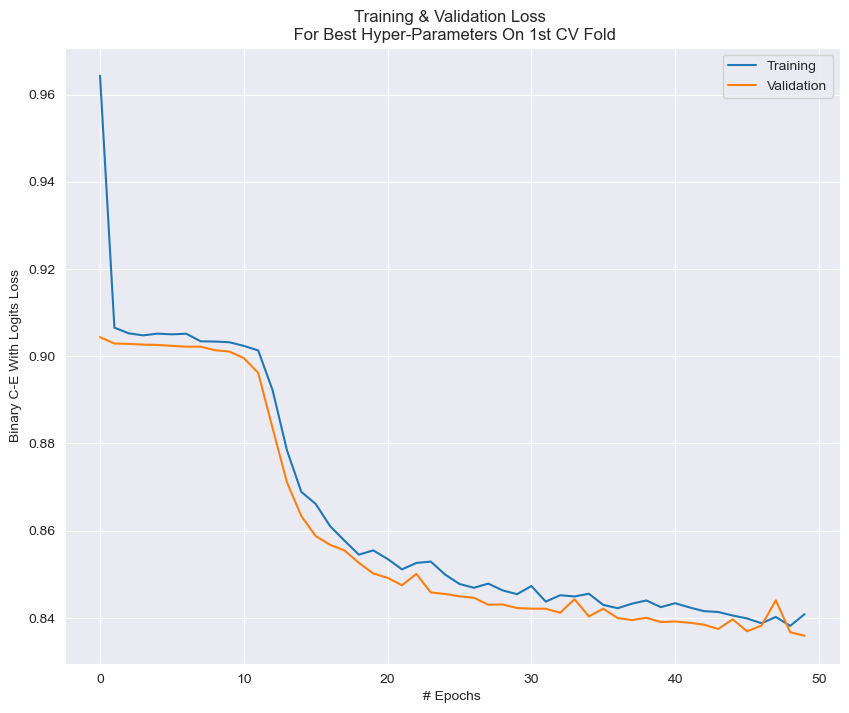

In [20]:
# Plotting the Learning Curves of the Training & Validation Losses of the Best Combination/Configuration of Hyper-Parameters
    
plt.figure( figsize = (10, 8) )


plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_Losses_of_All_5_CV_Folds" ][0], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_Losses_of_All_CV_Folds" ][0], label = "Validation" )


plt.title( "Training & Validation Loss \n For Best Hyper-Parameters On 1st CV Fold", fontsize = 12 )
    
plt.ylabel( "Binary C-E With Logits Loss", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation Binary C-E With Logits Loss For Best HPs On 1st CV Fold.png")

plt.show()



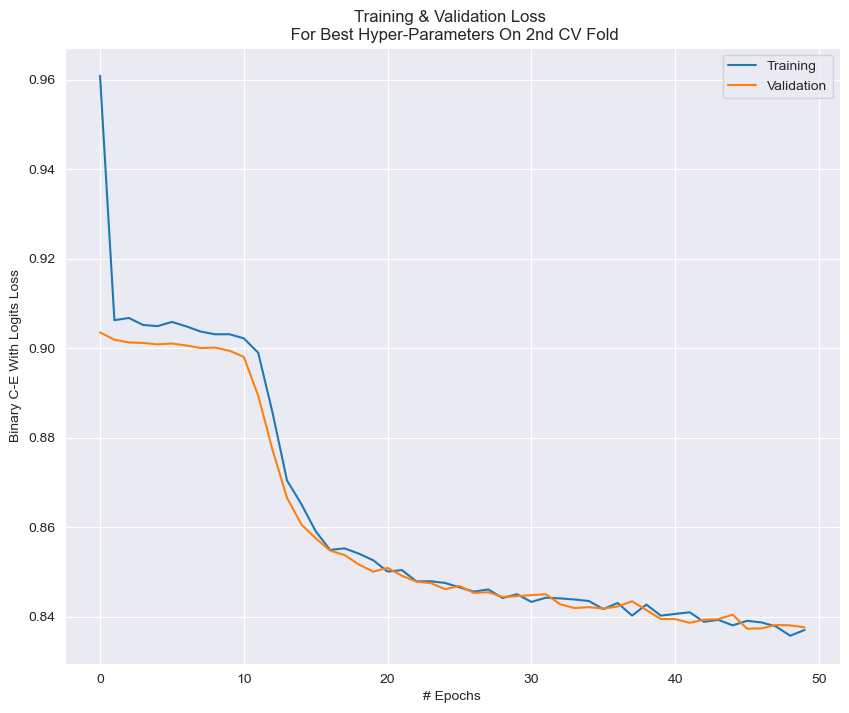

In [21]:
# Plotting the Learning Curves of the Training & Validation Losses of the Best Combination/Configuration of Hyper-Parameters
    
plt.figure( figsize = (10, 8) )


plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_Losses_of_All_5_CV_Folds" ][1], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_Losses_of_All_CV_Folds" ][1], label = "Validation" )


plt.title( "Training & Validation Loss \n For Best Hyper-Parameters On 2nd CV Fold", fontsize = 12 )
    
plt.ylabel( "Binary C-E With Logits Loss", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation Binary C-E With Logits Loss For Best HPs On 2nd CV Fold.png")

plt.show()



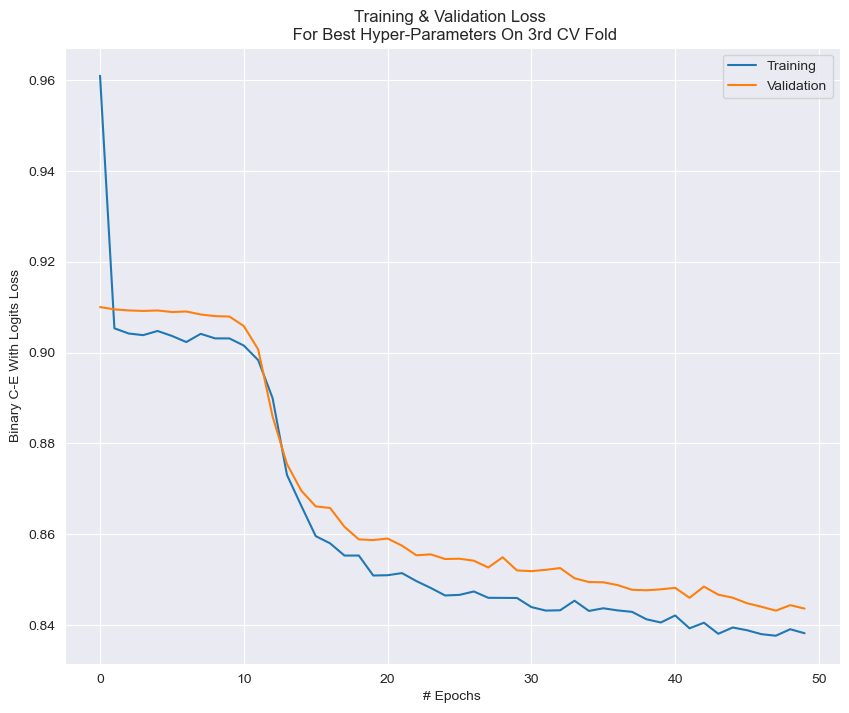

In [22]:
# Plotting the Learning Curves of the Training & Validation Losses of the Best Combination/Configuration of Hyper-Parameters
    
plt.figure( figsize = (10, 8) )


plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_Losses_of_All_5_CV_Folds" ][2], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_Losses_of_All_CV_Folds" ][2], label = "Validation" )


plt.title( "Training & Validation Loss \n For Best Hyper-Parameters On 3rd CV Fold", fontsize = 12 )
    
plt.ylabel( "Binary C-E With Logits Loss", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation Binary C-E With Logits Loss For Best HPs On 3rd CV Fold.png")

plt.show()



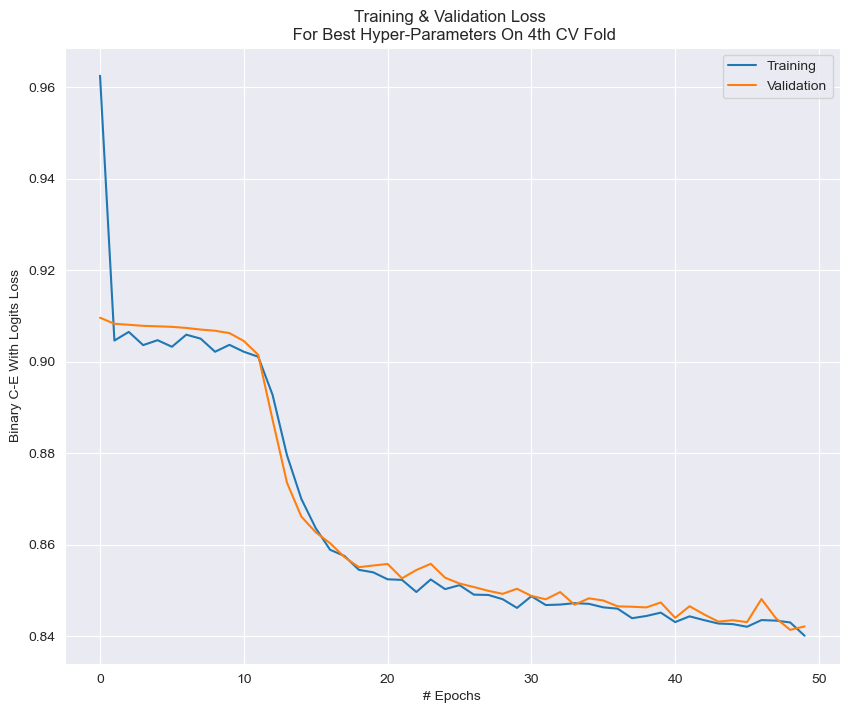

In [23]:
# Plotting the Learning Curves of the Training & Validation Losses of the Best Combination/Configuration of Hyper-Parameters
    
plt.figure( figsize = (10, 8) )


plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_Losses_of_All_5_CV_Folds" ][3], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_Losses_of_All_CV_Folds" ][3], label = "Validation" )


plt.title( "Training & Validation Loss \n For Best Hyper-Parameters On 4th CV Fold", fontsize = 12 )
    
plt.ylabel( "Binary C-E With Logits Loss", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation Binary C-E With Logits Loss For Best HPs On 4th CV Fold.png")

plt.show()



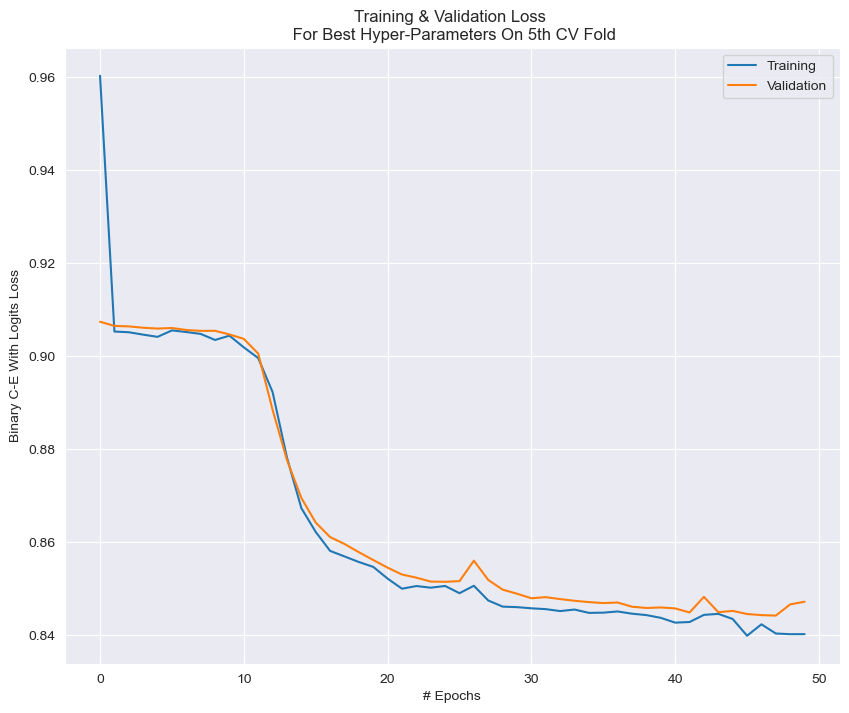

In [24]:
# Plotting the Learning Curves of the Training & Validation Losses of the Best Combination/Configuration of Hyper-Parameters
    
plt.figure( figsize = (10, 8) )


plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_Losses_of_All_5_CV_Folds" ][4], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_Losses_of_All_CV_Folds" ][4], label = "Validation" )


plt.title( "Training & Validation Loss \n For Best Hyper-Parameters On 5th CV Fold", fontsize = 12 )
    
plt.ylabel( "Binary C-E With Logits Loss", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation Binary C-E With Logits Loss For Best HPs On 5th CV Fold.png")

plt.show()



### History of Training & Validation ROC AUC-Scores

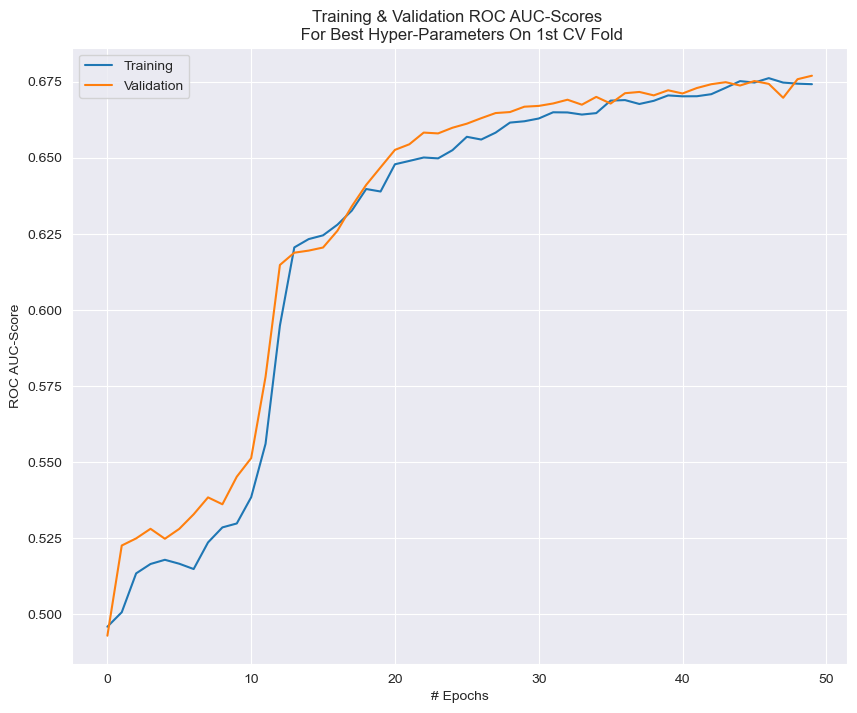

In [25]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][0], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][0], label = "Validation" )


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 1st CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 1st CV Fold.png")

plt.show()

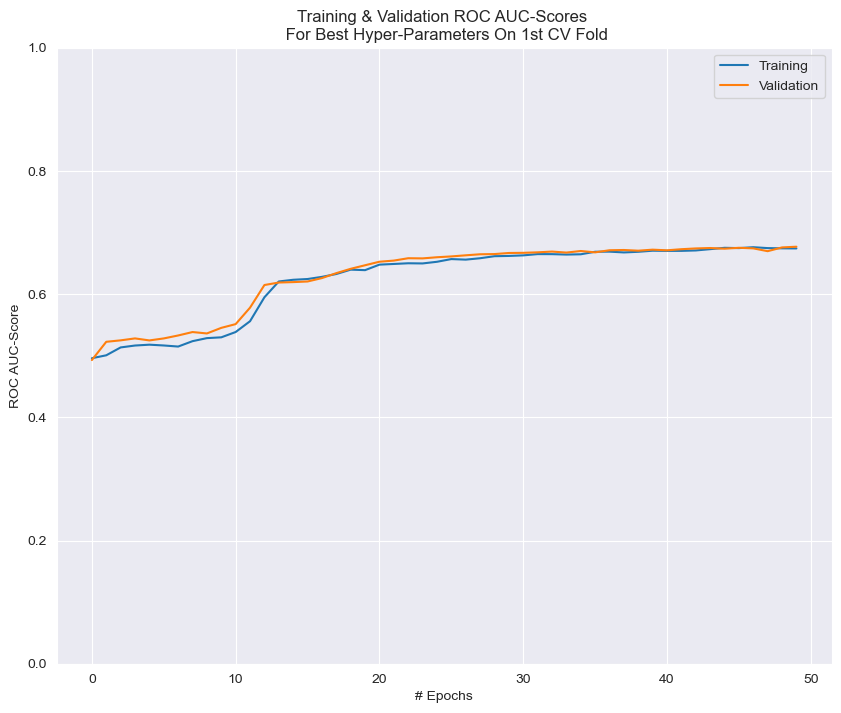

In [30]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][0], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][0], label = "Validation" )

plt.ylim([0.0, 1.0])


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 1st CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 1st CV Fold (2).png")

plt.show()

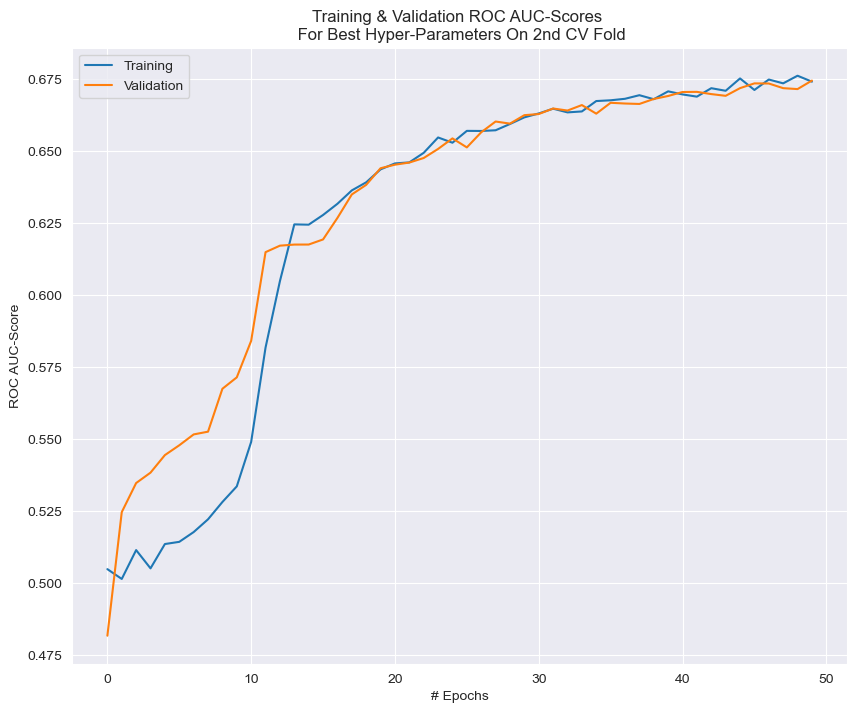

In [26]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][1], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][1], label = "Validation" )


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 2nd CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 2nd CV Fold.png")

plt.show()

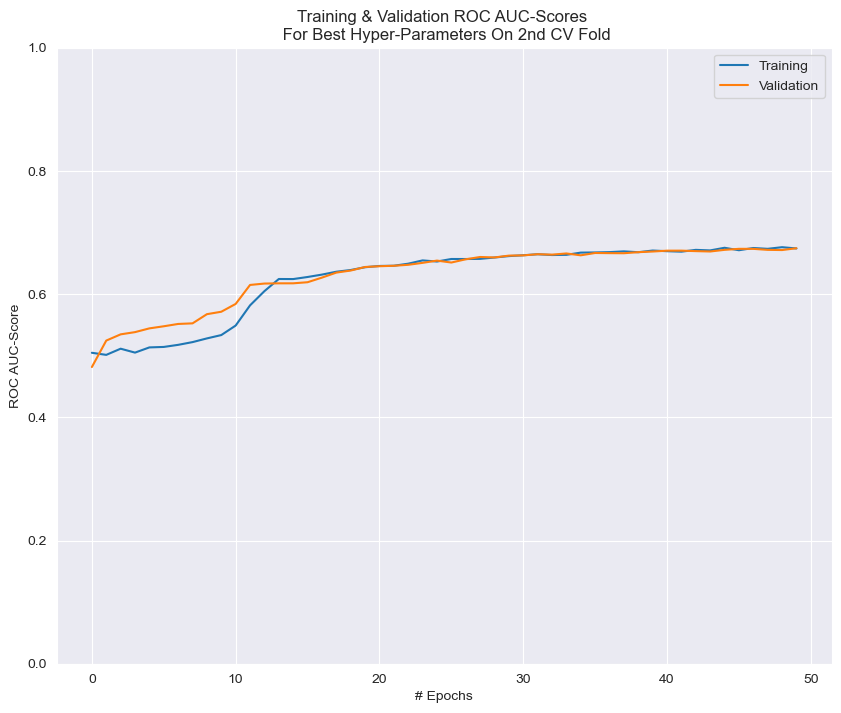

In [33]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][1], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][1], label = "Validation" )

plt.ylim([0.0, 1.0])


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 2nd CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 2nd CV Fold (2).png")

plt.show()

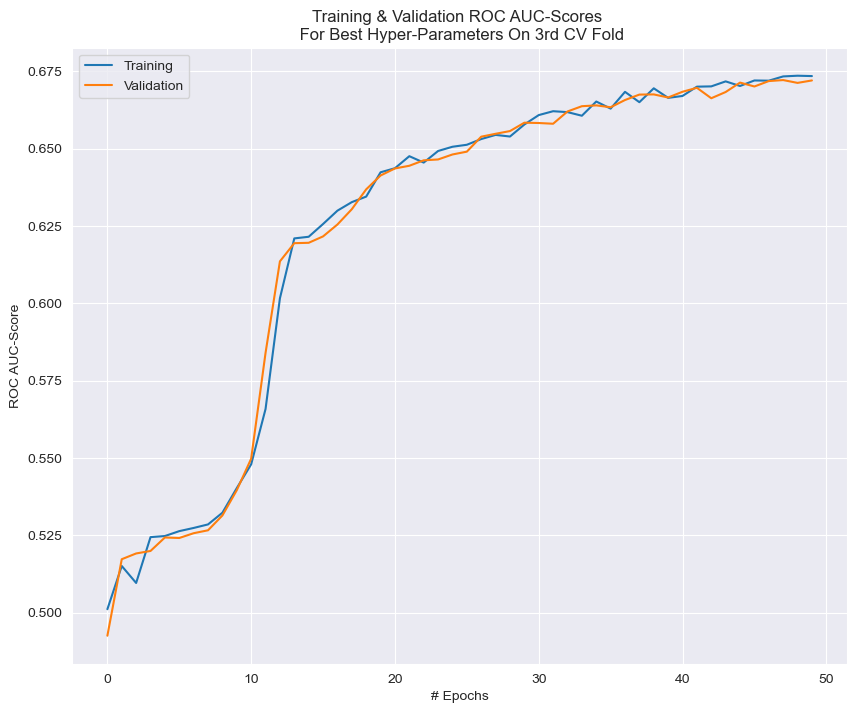

In [34]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][2], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][2], label = "Validation" )


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 3rd CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 3rd CV Fold.png")

plt.show()

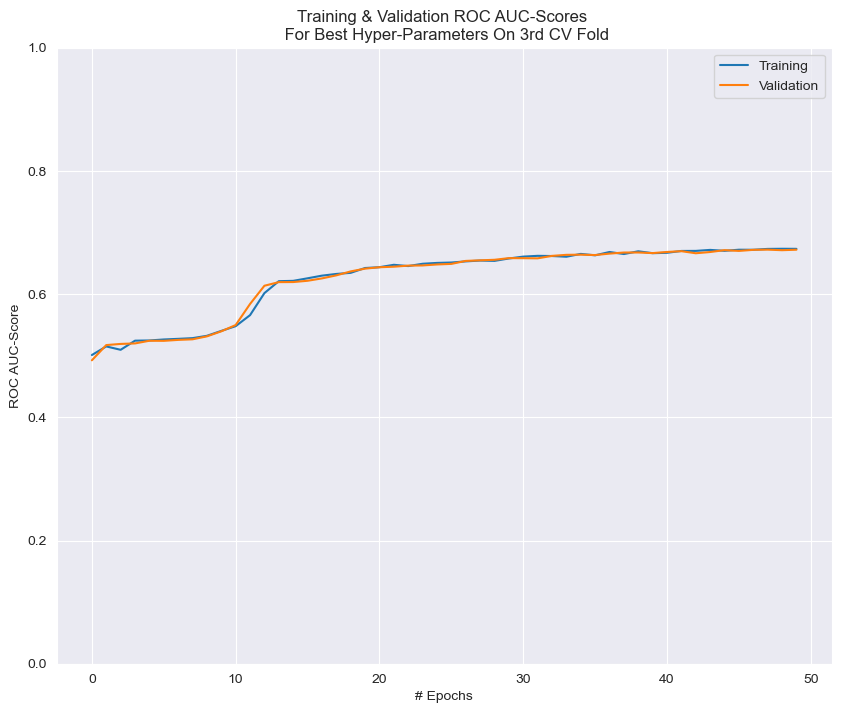

In [32]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][2], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][2], label = "Validation" )

plt.ylim([0.0, 1.0])


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 3rd CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 3rd CV Fold (2).png")

plt.show()

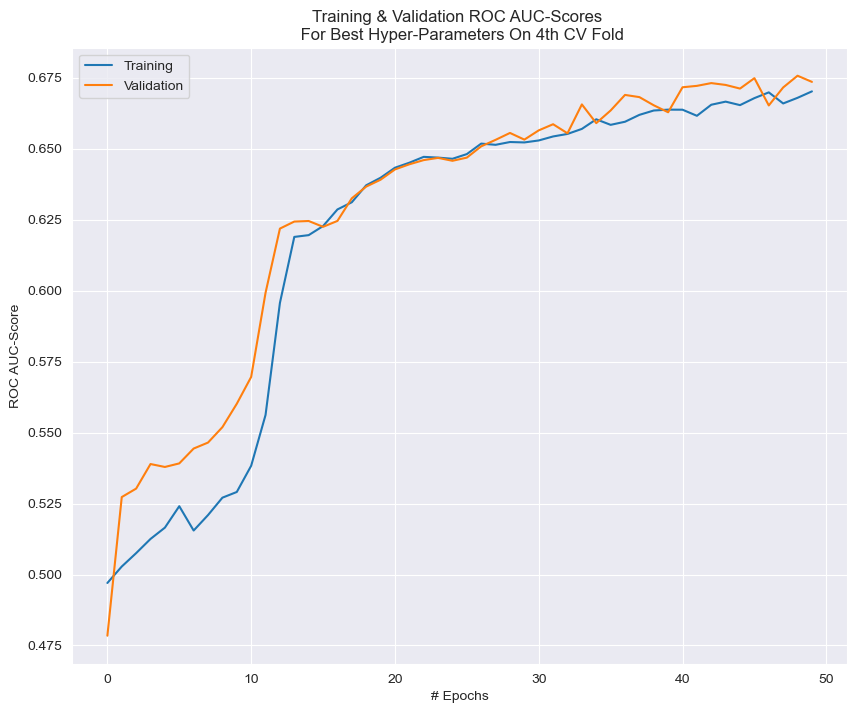

In [28]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][3], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][3], label = "Validation" )


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 4th CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 4th CV Fold.png")

plt.show()

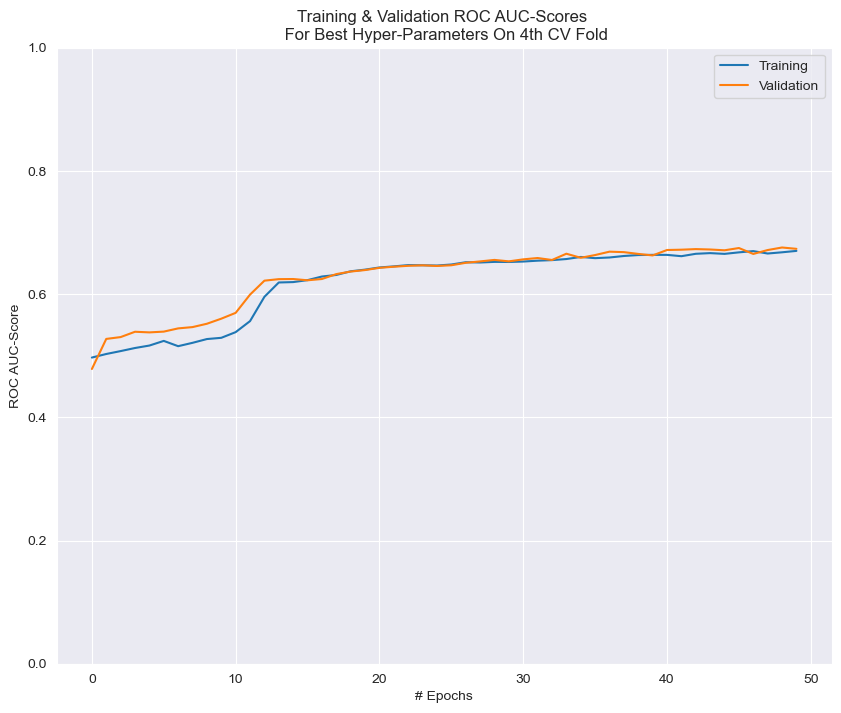

In [35]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][3], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][3], label = "Validation" )

plt.ylim([0.0, 1.0])


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 4th CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 4th CV Fold (2).png")

plt.show()

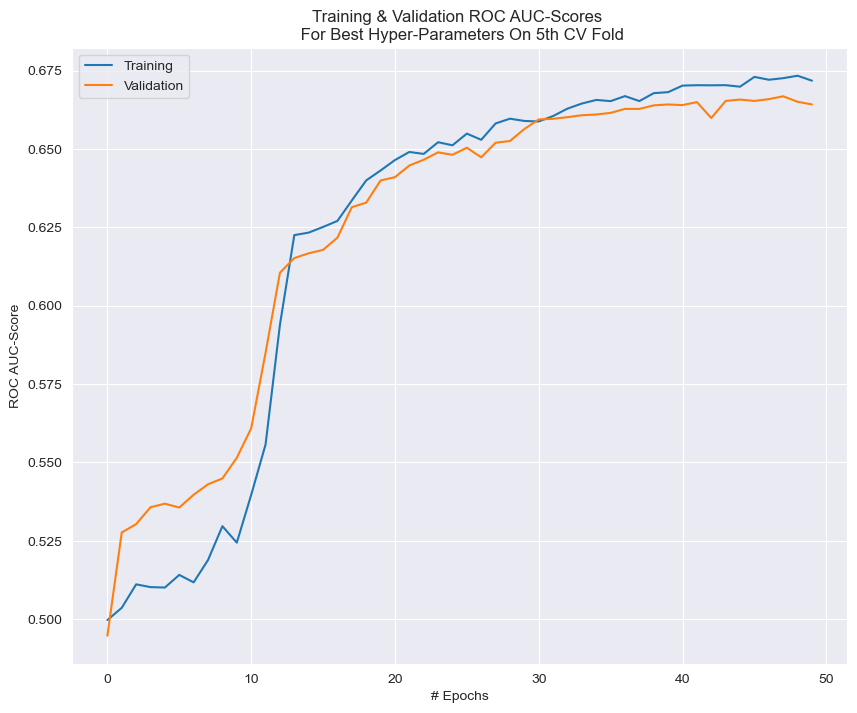

In [29]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][4], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][4], label = "Validation" )


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 5th CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 5th CV Fold.png")

plt.show()

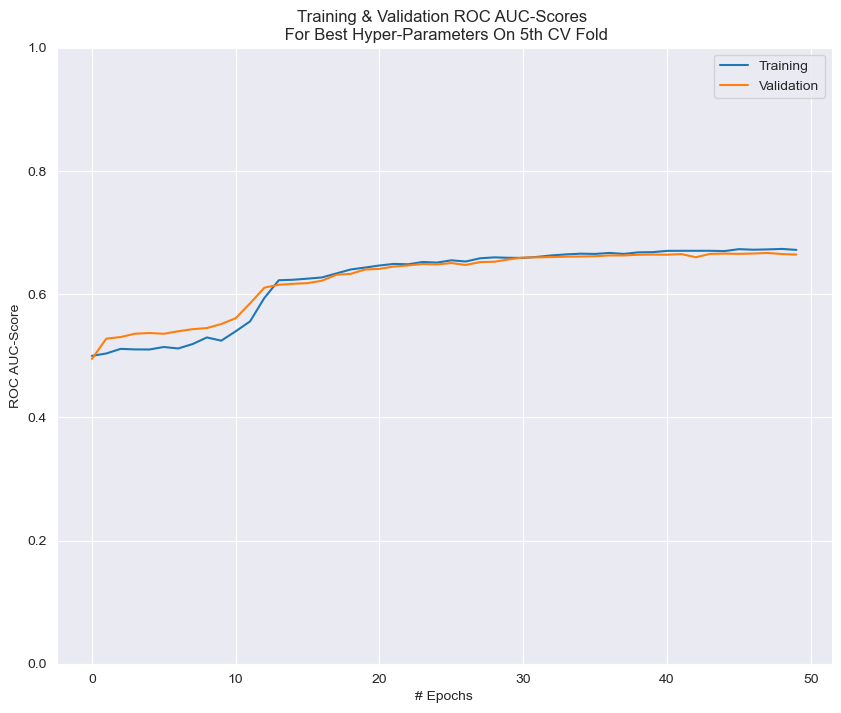

In [36]:
# Plotting the Learning Curves of the Training & Validation ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

plt.figure( figsize = (10, 8) )

plt.plot( Best_HP_Combination_Performance_dict[ "Training_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][4], label = "Training" )
plt.plot( Best_HP_Combination_Performance_dict[ "Validation_Histories_of_ROC_AUC_Scores_of_All_CV_Folds" ][4], label = "Validation" )

plt.ylim([0.0, 1.0])


plt.title( "Training & Validation ROC AUC-Scores \n For Best Hyper-Parameters On 5th CV Fold", fontsize = 12 )

plt.ylabel( "ROC AUC-Score", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend()

plt.savefig(f"Figures/Training and Validation ROC AUC-Score For Best HPs On 5th CV Fold (2).png")

plt.show()

___
___

## Training With Best Hyper-Parameters On Full Training Dataset + Testing On Hold-Out Test Dataset

In [22]:
class HGT_Model_Simple_Final(torch.nn.Module):
    
    def __init__(self, num_HGTConv_layers, hidden_NN_node_units, num_attention_heads, message_aggregation_strategy, dropout_rate, global_graph_pooling_strategy, random_seed):
        
        super(HGT_Model_Simple_Final, self).__init__()

        self.Random_Seed = random_seed
        
        torch.manual_seed( self.Random_Seed )

        self.Output_Hidden_NN_Node_Units = hidden_NN_node_units

        self.Dropout_Rate = dropout_rate   # Store Dropout-Rate As a Class Attribute
        self.Global_Graph_Pooling_Strategy = global_graph_pooling_strategy   # Store Global Graph Pooling Strategy As a Class Attribute

        
        self.HGT_Convs_list = torch.nn.ModuleList()

        for Layer_i in range(num_HGTConv_layers):
            
            Input_Hidden_NN_Node_Units = hidden_NN_node_units if Layer_i > 0 else -1

            HGT_Convolutional_layer = HGTConv( in_channels = Input_Hidden_NN_Node_Units, out_channels = self.Output_Hidden_NN_Node_Units, metadata = First_Training_Graph.metadata(),
                                               heads = num_attention_heads, group = message_aggregation_strategy )

            self.HGT_Convs_list.append(HGT_Convolutional_layer)

        
        
        # Adjusted (i.e. `2 *`) For Combined Features From Nodes & Edges
    
        self.Final_Readout_Linear_Layer = Linear( in_channels = 2 * self.Output_Hidden_NN_Node_Units, out_channels = 1 )   # out_channels = 1  <==>  Because We Are Doing Binary Classification



    
    def forward(self, x_dict, edge_index_dict, ball_batch_index, player_batch_index):

        
        # HGT Convolutional Layers
        
        for HGT_Convolution in self.HGT_Convs_list:
            
            x_dict = HGT_Convolution( x_dict, edge_index_dict )
            
            x_dict = { key : F.relu(x) for key, x in x_dict.items() }
            
            x_dict = { key : F.dropout( x, p = self.Dropout_Rate, training = self.training ) for key, x in x_dict.items() }

        

        # Global Graph Pooling Strategy
        
        Pooling_Function = global_mean_pool if self.Global_Graph_Pooling_Strategy == "mean" else \
                           global_add_pool if self.Global_Graph_Pooling_Strategy == "sum" else \
                           global_max_pool


        
        # Pooling For Both Node Types
        
        Ball_Node_Features_pooling = Pooling_Function( x_dict["Ball"], ball_batch_index )
        
        Player_Node_Features_pooling = Pooling_Function( x_dict["Player"], player_batch_index )


        
        # Combining Node- & Edge-Features
        
        Combined_Node_Features_Embeddings = torch.cat( [Ball_Node_Features_pooling, Player_Node_Features_pooling], dim = 1 )
        

        
        Output = self.Final_Readout_Linear_Layer(Combined_Node_Features_Embeddings)
        

        return Output



In [23]:
def Test_GNN_Model(GNN_model, testing_loader, criterion):

    GNN_model.eval()
    
    Total_Loss = 0


    y_Test_True_Labels = []
    
    y_Test_Predicted_Positive_Class_Label_Probabilities = []
    
        
    # Initialize TorchMetrics Metrics
    Test_ROC_AUC_Metric = AUROC( task = "binary" )
    Confusion_Matrix = ConfusionMatrix( task = "binary", threshold = 0.5 )   # Has Form  -->  [[TN], [FP]]
                                                                                           #  [[FN], [TP]]

    Test_Precision_Metric = Precision( task = "binary", threshold = 0.5 )
    Test_Recall_Metric = Recall( task = "binary", threshold = 0.5 )
    Test_F1_Score_Metric = F1Score( task = "binary", threshold = 0.5 )
    

    with torch.no_grad():
        for Loader_Batch_Data in testing_loader:

            Test_Model_Output = GNN_model( x_dict=Loader_Batch_Data.x_dict, edge_index_dict=Loader_Batch_Data.edge_index_dict,
                                           ball_batch_index=Loader_Batch_Data["Ball"].batch, player_batch_index=Loader_Batch_Data["Player"].batch )

            Loss = criterion( Test_Model_Output.view(-1), Loader_Batch_Data.y.float() )
            
            Total_Loss += Loss.item()

            # Calculating the probability and predicted labels
            y_Test_Predicted_Positive_Class_Label_Probability = torch.sigmoid( Test_Model_Output.squeeze() )

            # Applying a Threshold To Determine the Predicted Class Label
            Classifying_Threshold = 0.5
        
            # Representing the Class Label Classification of the Shot
            y_Test_Predicted_Class_Label = ( y_Test_Predicted_Positive_Class_Label_Probability >= Classifying_Threshold ).float()  # Converts To `0.0` or `1.0` Based On the Set `Classifying_Threshold`


            y_Test_True_Labels.append( Loader_Batch_Data.y )   # .y.cpu()
    
            y_Test_Predicted_Positive_Class_Label_Probabilities.append( y_Test_Predicted_Positive_Class_Label_Probability.view(-1) )   # .view(-1).cpu()
            
            

            # Update TorchMetrics
            Test_ROC_AUC_Metric.update( y_Test_Predicted_Positive_Class_Label_Probability, Loader_Batch_Data.y )
            Confusion_Matrix.update( y_Test_Predicted_Class_Label, Loader_Batch_Data.y )
            Test_Precision_Metric.update( y_Test_Predicted_Class_Label, Loader_Batch_Data.y )
            Test_Recall_Metric.update( y_Test_Predicted_Class_Label, Loader_Batch_Data.y )
            Test_F1_Score_Metric.update( y_Test_Predicted_Class_Label, Loader_Batch_Data.y )
            # Test_Brier_Score_Metric.update( y_Test_Predicted_Positive_Class_Label_Probability, Loader_Batch_Data.y )

    # Compute metrics
    Test_ROC_AUC_Score = Test_ROC_AUC_Metric.compute()
    Confusion_Matrix_tensor_with_matrix = Confusion_Matrix.compute()
    Test_Precision_Score = Test_Precision_Metric.compute()
    Test_Recall_Score = Test_Recall_Metric.compute()
    Test_F1_Score = Test_F1_Score_Metric.compute()
    

    Test_Loss = Total_Loss / len(testing_loader)
    

    # Flatten the Lists / Concatenate Tensors
    y_Test_True_Labels = torch.cat(y_Test_True_Labels)
    y_Test_Predicted_Positive_Class_Label_Probabilities = torch.cat(y_Test_Predicted_Positive_Class_Label_Probabilities)



    Test_Brier_Score = brier_score_loss(y_Test_True_Labels.tolist(), y_Test_Predicted_Positive_Class_Label_Probabilities.tolist())

    

    return y_Test_True_Labels, y_Test_Predicted_Positive_Class_Label_Probabilities, Test_Loss, Test_Brier_Score, Test_ROC_AUC_Score, Confusion_Matrix_tensor_with_matrix, Test_Precision_Score, Test_Recall_Score, Test_F1_Score


Training-Testing Procedure:   0%|          | 0/5 [00:00<?, ?it/s]

Training Best HGT Model On Entire Training Dataset -- Train-Test Iteration #1:   0%|          | 0/50 [00:00<?,…

RESULTS OF ==> TRAIN-TEST ITERATION #1 

     Binary Coress-Entropy (With Logits) Loss = 0.8336857914924621 

     Brier Score = 0.15876584448939268 

     ROC AUC-Score = 0.6710909008979797 

     Confusion Matrix = 
tensor([[1836,  300],
        [ 175,  105]]) 

     Precision Score = 0.25925925374031067 

     Recall (Sensitivity) Score = 0.375 

     F1-Score = 0.30656933784484863 



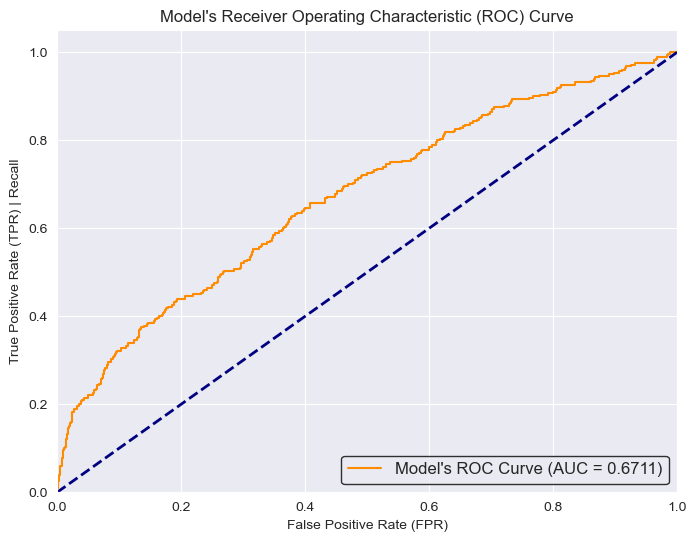

Training Best HGT Model On Entire Training Dataset -- Train-Test Iteration #2:   0%|          | 0/50 [00:00<?,…

RESULTS OF ==> TRAIN-TEST ITERATION #2 

     Binary Coress-Entropy (With Logits) Loss = 0.8456982254981995 

     Brier Score = 0.16380489455361982 

     ROC AUC-Score = 0.6559106111526489 

     Confusion Matrix = 
tensor([[1797,  339],
        [ 172,  108]]) 

     Precision Score = 0.24161073565483093 

     Recall (Sensitivity) Score = 0.3857142925262451 

     F1-Score = 0.2971114218235016 



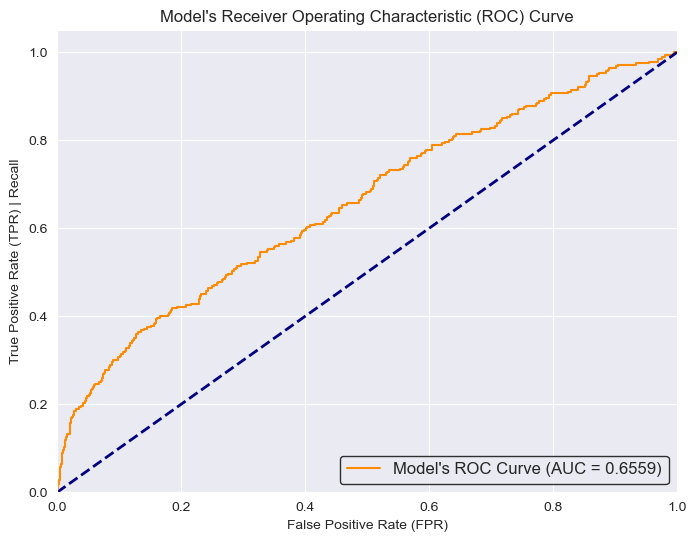

Training Best HGT Model On Entire Training Dataset -- Train-Test Iteration #3:   0%|          | 0/50 [00:00<?,…

RESULTS OF ==> TRAIN-TEST ITERATION #3 

     Binary Coress-Entropy (With Logits) Loss = 0.8333435893058777 

     Brier Score = 0.16030422322232704 

     ROC AUC-Score = 0.6671515703201294 

     Confusion Matrix = 
tensor([[1835,  301],
        [ 177,  103]]) 

     Precision Score = 0.25495049357414246 

     Recall (Sensitivity) Score = 0.3678571283817291 

     F1-Score = 0.30116960406303406 



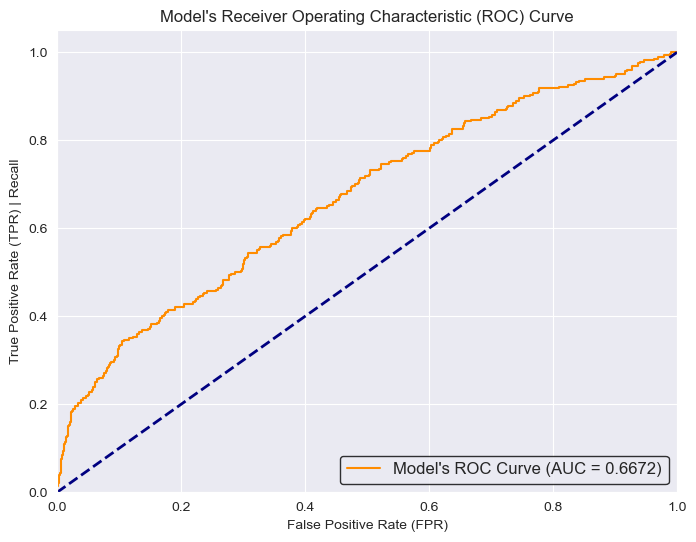

Training Best HGT Model On Entire Training Dataset -- Train-Test Iteration #4:   0%|          | 0/50 [00:00<?,…

RESULTS OF ==> TRAIN-TEST ITERATION #4 

     Binary Coress-Entropy (With Logits) Loss = 0.8453189611434937 

     Brier Score = 0.16813440620272968 

     ROC AUC-Score = 0.6563870906829834 

     Confusion Matrix = 
tensor([[1794,  342],
        [ 174,  106]]) 

     Precision Score = 0.2366071492433548 

     Recall (Sensitivity) Score = 0.37857142090797424 

     F1-Score = 0.29120880365371704 



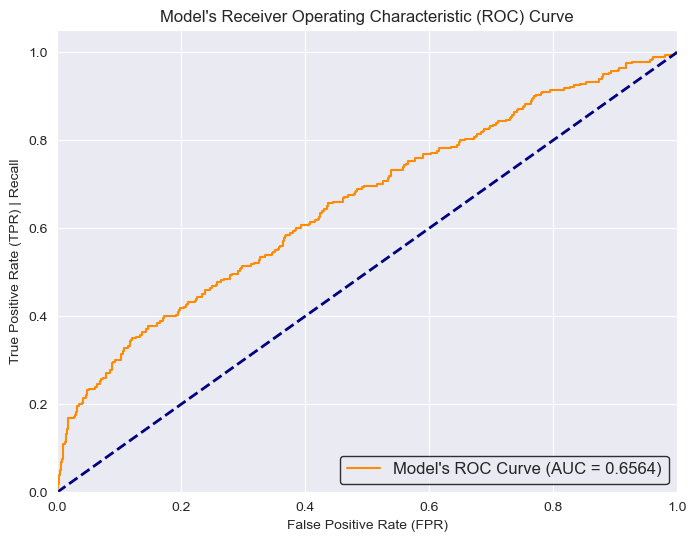

Training Best HGT Model On Entire Training Dataset -- Train-Test Iteration #5:   0%|          | 0/50 [00:00<?,…

RESULTS OF ==> TRAIN-TEST ITERATION #5 

     Binary Coress-Entropy (With Logits) Loss = 0.8331479787826538 

     Brier Score = 0.1597880767158861 

     ROC AUC-Score = 0.672603964805603 

     Confusion Matrix = 
tensor([[1818,  318],
        [ 174,  106]]) 

     Precision Score = 0.25 

     Recall (Sensitivity) Score = 0.37857142090797424 

     F1-Score = 0.3011363744735718 



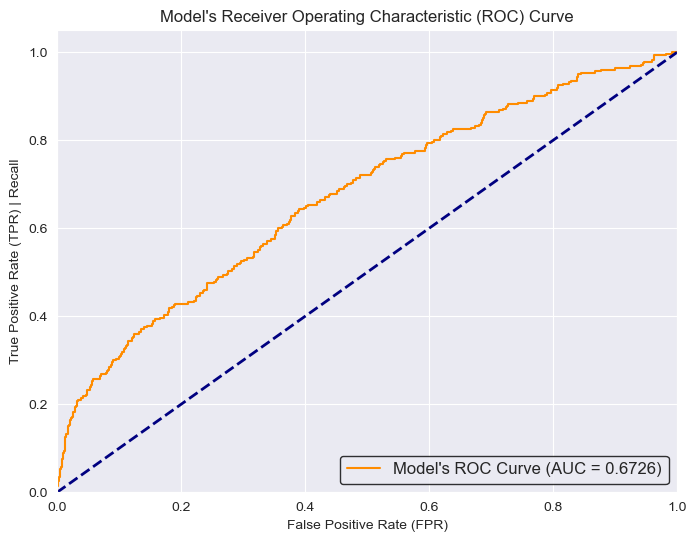

In [24]:
logging.basicConfig( filename = "Log of Simple HGT Model -- Final Train-Test Procedure.log", level = logging.INFO, format = "%(asctime)s - %(levelname)s - %(message)s" )

logging.info("Model Selection Is Over !")
logging.info("===============================================================================================================================================================================================================")
logging.info(f"Final (Re-)Training On the Entire Training Dataset, Using the Best HPs: {Best_HPs_dict} !  ↓")
logging.info("===============================================================================================================================================================================================================")

Num_of_Train_Test_Iterations = Num_K_Splits  # == 5
# Num_Epochs = 50

# Initialize the Dictionary of Histories of Losses & ROC AUC-Scores (Values) Per Train-Test Iteration (Keys)
Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict = {}

# Initialize the Dictionary of Test Class Labels' Predicted Probabilities & Class Label Classification/Prediction (Values) Per Train-Test Iteration (Keys)
Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict = {}

# Initialize the Dictionary of Test Metrics' Scores (Values) Per Train-Test Iteration (Keys)
Test_Metrics_Scores_Per_Train_Test_Iteration_dict = {}

for Train_Test_Iteration_ID in tqdm( range(0, Num_of_Train_Test_Iterations), desc = "Training-Testing Procedure" ):
    
    Train_Test_Iteration_Counter = Train_Test_Iteration_ID + 1    
    logging.info("===============================================================================================================================================================================================================")
    logging.info(f"TRAIN-TEST ITERATION #{Train_Test_Iteration_Counter}")

    # Initialize the HGT Model With the Best Hyper-Parameters
    Best_HGT_Model = HGT_Model_Simple_Final( num_HGTConv_layers = Best_HPs_dict["Num_HGTConv_Layers"], hidden_NN_node_units = Best_HPs_dict["Hidden_NN_Node_Units"],
                                             num_attention_heads = Best_HPs_dict["Num_Attention_Heads"], message_aggregation_strategy = Best_HPs_dict["Message_Aggregation_Strategy"],
                                             dropout_rate = Best_HPs_dict["Dropout_Rate"], global_graph_pooling_strategy = Best_HPs_dict["Global_Graph_Pooling_Strategy"], random_seed = Train_Test_Iteration_Counter ).to(Device)

    Best_Optimizer = torch.optim.Adam( Best_HGT_Model.parameters(), lr = Best_HPs_dict["Learning_Rate"], weight_decay = Best_HPs_dict["Weight_Decay"] )

    Loss_Function = torch.nn.BCEWithLogitsLoss( pos_weight = Best_HPs_dict["Positive_Class_Weight"] )

    Full_Training_DataLoader = DataLoader( Training_Simple_Dataset, batch_size = Best_HPs_dict["Batch_Size"], shuffle = True )   # Data Re-Shuffled At Every Epoch

    # Initialize the Best Final Training ROC AUC-Score For the Current Train-Test Iteration
    Best_Final_Training_ROC_AUC_Score = 0

    # Initialize the Final Training History of Losses & ROC AUC-Scores For the Current Train-Test Iteration
    Training_Final_History_of_Losses_list = []
    Training_Final_History_of_ROC_AUC_Scores_list = []

    # Final Training On the Full Training Dataset (i.e. Training + Validation Sub-Datasets Together)
    for Epoch in tqdm( range(0, Num_Epochs), desc = f"Training Best HGT Model On Entire Training Dataset -- Train-Test Iteration #{Train_Test_Iteration_Counter}" ):
    
        Training_Loss, Training_ROC_AUC_Score = Train_GNN_Model( GNN_model = Best_HGT_Model, training_loader = Full_Training_DataLoader, optimizer = Best_Optimizer, criterion = Loss_Function )
        
        logging.info(f"EPOCH #{Epoch+1} | Full Training Loss = {Training_Loss} | Full Training ROC AUC-Score = {Training_ROC_AUC_Score}")

        # Place Values From Training Loop Into the Train-Test Iteration Loop            
        Training_Final_History_of_Losses_list.append(Training_Loss)
        Training_Final_History_of_ROC_AUC_Scores_list.append(Training_ROC_AUC_Score)
    
        if Training_ROC_AUC_Score > Best_Final_Training_ROC_AUC_Score:  # To Update & Save Best Model Weights For the Current Train-Test Iteration
            
            Best_Final_Training_ROC_AUC_Score = Training_ROC_AUC_Score
            logging.info(f"FOUND NEW BEST MODEL (WEIGHTS) @ EPOCH #{Epoch+1} --> Updating Best Model Weights")                
            logging.info(f"EPOCH #{Epoch+1} | Full Training Loss = {Training_Loss} | *** Full Training ROC AUC-Score = {Training_ROC_AUC_Score} ***")        

            # Save the HGT Model's Learned Weights For the Best Model    
            torch.save( Best_HGT_Model.state_dict(), f"Learned Weights of Best HGT Simple Model On Final Train-Test Procedure/Best Weights of Final Training In Train-Test Iteration #{Train_Test_Iteration_Counter}.pth" )
    
    Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ] = { "Final_Training_History_of_Losses" : Training_Final_History_of_Losses_list,
                                                                                                      "Final_Training_History_of_ROC_AUC_Scores" : Training_Final_History_of_ROC_AUC_Scores_list }    
    # Evaluate/Test On the Test Dataset
    logging.info("===============================================================================================================================================================================================================")
    logging.info(f"Final Evaluation/Testing of the Simple HGT Model On the Hold-Out Test Dataset - For Train-Test Iteration #{Train_Test_Iteration_Counter} !  ↓")
    logging.info("===============================================================================================================================================================================================================")

    Test_DataLoader = DataLoader( dataset = Test_Simple_Dataset, batch_size = 512, shuffle = False )   # Data NOT Re-Shuffled At Every Epoch
    # Test_DataLoader = DataLoader( dataset = Test_Simple_Dataset, batch_size = Best_HPs_dict["Batch_Size"], shuffle = False )   # Data NOT Re-Shuffled At Every Epoch

    Loss_Function = torch.nn.BCEWithLogitsLoss( pos_weight = Positive_Class_Weight_tensor )
    # Loss_Function = torch.nn.BCEWithLogitsLoss( pos_weight = Best_HPs_dict["Positive_Class_Weight"] )

    # Load the Best HGT Model Learned Weights
    Best_HGT_Model.load_state_dict( torch.load( f"Learned Weights of Best HGT Simple Model On Final Train-Test Procedure/Best Weights of Final Training In Train-Test Iteration #{Train_Test_Iteration_Counter}.pth" ) )

    y_Test_True_Labels, y_Test_Predicted_Positive_Class_Label_Probabilities, Test_Loss, Test_Brier_Score, Test_ROC_AUC_Score, Confusion_Matrix, Test_Precision_Score, Test_Recall_Score, Test_F1_Score = Test_GNN_Model( GNN_model = Best_HGT_Model, testing_loader = Test_DataLoader, criterion = Loss_Function )
        
    logging.info(f"RESULTS OF ==> TRAIN-TEST ITERATION #{Train_Test_Iteration_Counter}")
    print(f"RESULTS OF ==> TRAIN-TEST ITERATION \033[91m\033[1m\033[4m#{Train_Test_Iteration_Counter}\033[0m", "\n")
    
    # logging.info(f"     `y' Test True Class Labels of the Hold-Out Test Dataset = {y_Test_True_Labels}")
    # logging.info(f"     `y' Test Predicted Class Labels' Probabilities of the Hold-Out Test Dataset = {y_Test_Predicted_Positive_Class_Label_Probabilities}")

    # Representing the Class Label Classification/Prediction of the Shot
    Classifying_Threshold = 0.5
    y_Test_Predicted_Class_Labels = ( y_Test_Predicted_Positive_Class_Label_Probabilities >= Classifying_Threshold ).float()  # Converts To `0.0` or `1.0` Based On the Set `Classifying_Threshold`
    # logging.info(f"     `y' Test Predicted Class Labels of the Hold-Out Test Dataset = {y_Test_Predicted_Class_Labels}")

    Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ] = { "Test True Class Labels" : y_Test_True_Labels,
                                                                                                                        "Test Class Labels' Predicted Probabilities" : y_Test_Predicted_Positive_Class_Label_Probabilities,
                                                                                                                        "Test Predicted/Classified Class Labels" : y_Test_Predicted_Class_Labels }
    
    Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ] = { "Test Binary Coress-Entropy (With Logits) Loss" : Test_Loss,
                                                                                     "Test Brier-Score" : Test_Brier_Score,
                                                                                     "Test ROC AUC-Score" : Test_ROC_AUC_Score,
                                                                                     "Test Confusion Matrix" : Confusion_Matrix,
                                                                                     "Test Precision Score" : Test_Precision_Score,
                                                                                     "Test Recall Score" : Test_Recall_Score,
                                                                                     "Test F1-Score" : Test_F1_Score }
    # Output the Test Evaluation Metrics
    logging.info(f"     Binary Coress-Entropy (With Logits) Loss = {Test_Loss}")
    print(f"     Binary Coress-Entropy (With Logits) Loss = \033[91m\033[1m\033[4m{Test_Loss}\033[0m", "\n")

    logging.info(f"     Brier Score = {Test_Brier_Score}")
    print(f"     Brier Score = \033[91m\033[1m\033[4m{Test_Brier_Score}\033[0m", "\n")

    logging.info(f"     ROC AUC-Score = {Test_ROC_AUC_Score}")
    print(f"     ROC AUC-Score = \033[91m\033[1m\033[4m{Test_ROC_AUC_Score}\033[0m", "\n")

    logging.info(f"     Confusion Matrix = {Confusion_Matrix}")
    print(f"     Confusion Matrix = \n\033[91m\033[1m\033[4m{Confusion_Matrix}\033[0m", "\n")

    logging.info(f"     Precision Score = {Test_Precision_Score}")
    print(f"     Precision Score = \033[91m\033[1m\033[4m{Test_Precision_Score}\033[0m", "\n")

    logging.info(f"     Recall (Sensitivity) Score = {Test_Recall_Score}")
    print(f"     Recall (Sensitivity) Score = \033[91m\033[1m\033[4m{Test_Recall_Score}\033[0m", "\n")

    logging.info(f"     F1-Score = {Test_F1_Score}")
    print(f"     F1-Score = \033[91m\033[1m\033[4m{Test_F1_Score}\033[0m", "\n")

    # Display the Test ROC Curve Plot For the Current Train-Test Iteration
    _ = TSHGTMFs.Plot_ROC_Curve_of_Unseen_Test_Set( y_test_true_class_labels = y_Test_True_Labels, y_test_pred_class_probabilities = y_Test_Predicted_Positive_Class_Label_Probabilities, figure_size = (8, 6) )

logging.info("===============================================================================================================================================================================================================")
logging.info("===============================================================================================================================================================================================================")
logging.info("Dictionary of Histories of Losses & ROC AUC-Scores (Values) Per Train-Test Iteration (Keys)")
logging.info(f"{Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict}")
logging.info("===============================================================================================================================================================================================================")
logging.info("===============================================================================================================================================================================================================")
logging.info("Dictionary of Test Class Labels' Predicted Probabilities & Class Label Classification/Prediction (Values) Per Train-Test Iteration (Keys)")
logging.info(f"{Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict}")
logging.info("===============================================================================================================================================================================================================")
logging.info("===============================================================================================================================================================================================================")
logging.info("Dictionary of Test Metrics' Scores (Values) Per Train-Test Iteration (Keys)")
logging.info(f"{Test_Metrics_Scores_Per_Train_Test_Iteration_dict}")

logging.info("===============================================================================================================================================================================================================")
logging.info("===============================================================================================================================================================================================================")
logging.info("===============================================================================================================================================================================================================")
logging.info(f"Final (Re-)Training On the Entire Training Dataset, Using the Best HPs + Testing/Evaluation On Hold-Out Test Dataset Is Over !  ↓")
logging.info("===============================================================================================================================================================================================================")
logging.info("===============================================================================================================================================================================================================")
logging.info("===============================================================================================================================================================================================================")


### **↑ Run-Time ≈ 20hrs**

___

## Visualizing the Final Training Losses + Training ROC AUC-Scores

In [61]:
# In the `Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict` Dictionary --> Convert All PyTorch Tensor Values Into Scalar Float Values

# Iterate Through Each `Train_Test_Iteration_ID`

for Train_Test_Iteration_ID in range(5):  # IDs Go From 0 To 4
    
    # Get the Dictionary For the Current Train-Test Iteration
    
    Train_Test_Iteration_dict = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ]
    

    # Converting the List of Tensors In `"Final_Training_History_of_ROC_AUC_Scores"` To a List of Scalar Float Values
    
    Train_Test_Iteration_dict[ "Final_Training_History_of_ROC_AUC_Scores" ] = [ Training_ROC_AUC_Score.item() for Training_ROC_AUC_Score in Train_Test_Iteration_dict[ "Final_Training_History_of_ROC_AUC_Scores" ] ]
        

    # Updating the Dictionary
    
    Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ] = Train_Test_Iteration_dict
        

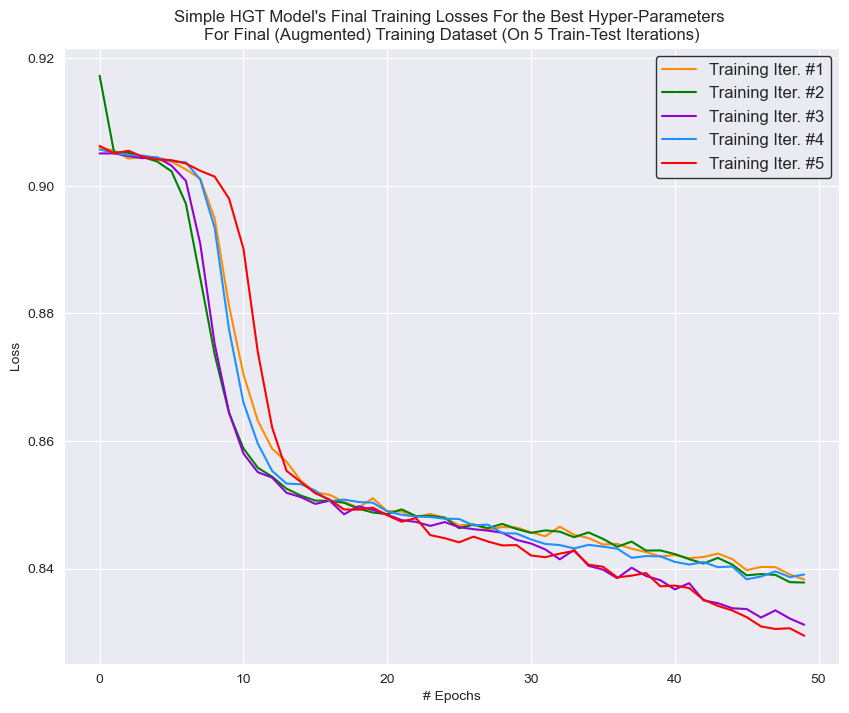

In [74]:
# Plotting the Learning Curves of the Final Training Losses of the Best Combination/Configuration of Hyper-Parameters

Final_Training_History_Losses_For_Train_Test_Iteration_1 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 0 ][ "Final_Training_History_of_Losses" ]
Final_Training_History_Losses_For_Train_Test_Iteration_2 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 1 ][ "Final_Training_History_of_Losses" ]
Final_Training_History_Losses_For_Train_Test_Iteration_3 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 2 ][ "Final_Training_History_of_Losses" ]
Final_Training_History_Losses_For_Train_Test_Iteration_4 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 3 ][ "Final_Training_History_of_Losses" ]
Final_Training_History_Losses_For_Train_Test_Iteration_5 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 4 ][ "Final_Training_History_of_Losses" ]



plt.figure( figsize = (10, 8) )

plt.plot( Final_Training_History_Losses_For_Train_Test_Iteration_1, color = "darkorange", label = "Training Iter. #1" )
plt.plot( Final_Training_History_Losses_For_Train_Test_Iteration_2, color = "green", label = "Training Iter. #2" )
plt.plot( Final_Training_History_Losses_For_Train_Test_Iteration_3, color = "darkviolet", label = "Training Iter. #3" )
plt.plot( Final_Training_History_Losses_For_Train_Test_Iteration_4, color = "dodgerblue", label = "Training Iter. #4" )
plt.plot( Final_Training_History_Losses_For_Train_Test_Iteration_5, color = "red", label = "Training Iter. #5" )


plt.title( f"Simple HGT Model's Final Training Losses For the Best Hyper-Parameters \nFor Final (Augmented) Training Dataset (On {Num_of_Train_Test_Iterations} Train-Test Iterations)", fontsize = 12 )

plt.ylabel( "Loss", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend( loc = "upper right", edgecolor = "k", fontsize = "large" )

plt.savefig(f"Figures/Simple HGT Model's Final Training Losses For Best HPs For Final (Augmented) Training Dataset.png")

plt.show()


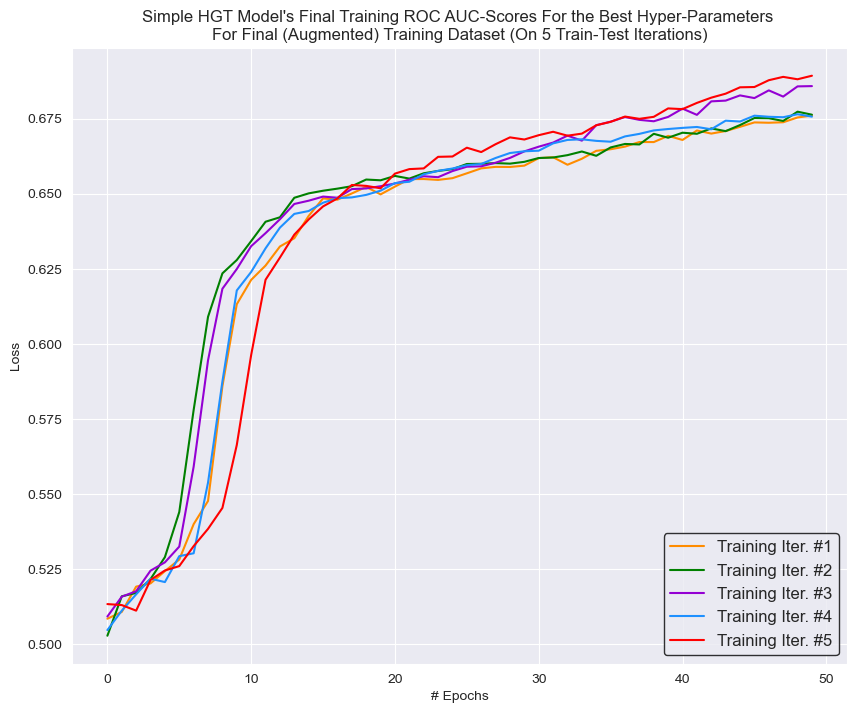

In [75]:
# Plotting the Learning Curves of the Final Training ROC AUC-Scores of the Best Combination/Configuration of Hyper-Parameters

Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_1 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 0 ][ "Final_Training_History_of_ROC_AUC_Scores" ]
Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_2 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 1 ][ "Final_Training_History_of_ROC_AUC_Scores" ]
Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_3 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 2 ][ "Final_Training_History_of_ROC_AUC_Scores" ]
Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_4 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 3 ][ "Final_Training_History_of_ROC_AUC_Scores" ]
Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_5 = Train_Test_Performance_and_Histories_Per_Train_Test_Iteration_dict[ 4 ][ "Final_Training_History_of_ROC_AUC_Scores" ]



plt.figure( figsize = (10, 8) )

plt.plot( Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_1, color = "darkorange", label = "Training Iter. #1" )
plt.plot( Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_2, color = "green", label = "Training Iter. #2" )
plt.plot( Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_3, color = "darkviolet", label = "Training Iter. #3" )
plt.plot( Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_4, color = "dodgerblue", label = "Training Iter. #4" )
plt.plot( Final_Training_History_ROC_AUC_Scores_For_Train_Test_Iteration_5, color = "red", label = "Training Iter. #5" )


plt.title( f"Simple HGT Model's Final Training ROC AUC-Scores For the Best Hyper-Parameters \nFor Final (Augmented) Training Dataset (On {Num_of_Train_Test_Iterations} Train-Test Iterations)", fontsize = 12 )

plt.ylabel( "Loss", fontsize = 10 )

plt.xlabel( "# Epochs", fontsize = 10 )


plt.legend( loc = "lower right", edgecolor = "k", fontsize = "large" )

plt.savefig(f"Figures/Simple HGT Model's Final Training ROC AUC-Scores For Best HPs For Final (Augmented) Training Dataset.png")

plt.show()


___

### Mean Test ROC AUC-Score

In [45]:
# List of Test ROC AUC-Scores In Every Train-Test Iteration

Test_ROC_AUC_Scores_Produced_In_Every_Train_Test_Iteration_list = [ Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 0 ]["Test ROC AUC-Score"], Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 1 ]["Test ROC AUC-Score"],
                                                                    Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 2 ]["Test ROC AUC-Score"], Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 3 ]["Test ROC AUC-Score"],
                                                                    Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 4 ]["Test ROC AUC-Score"] ]

# Mean Test ROC AUC-Score Produced By All Final Train-Test Iterations

Mean_Test_ROC_AUC_Score = np.mean( Test_ROC_AUC_Scores_Produced_In_Every_Train_Test_Iteration_list )

logging.info(f"Mean Test ROC AUC-Score = {Mean_Test_ROC_AUC_Score}")
print(f"Mean Test ROC AUC-Score = \033[91m\033[1m\033[4m{Mean_Test_ROC_AUC_Score}\033[0m", "\n")



# Calculate the Margin of Error of the Mean Test ROC AUC-Score of the Train-Test Iterations

STD_of_Mean_Test_ROC_AUC_Scores_Across_Train_Test_Iterations = np.std( Test_ROC_AUC_Scores_Produced_In_Every_Train_Test_Iteration_list, ddof = 1 )   # `ddof = 1` For Sample Standard Deviation

logging.info(f"Standard Deviation of the {Num_of_Train_Test_Iterations} Test ROC AUC-Scores of the Train-Test Iterations = {STD_of_Mean_Test_ROC_AUC_Scores_Across_Train_Test_Iterations}")
print(f"Standard Deviation of the {Num_of_Train_Test_Iterations} Test ROC AUC-Scores of the Train-Test Iterations = \033[91m\033[1m\033[4m{STD_of_Mean_Test_ROC_AUC_Scores_Across_Train_Test_Iterations}\033[0m", "\n")

SEM = STD_of_Mean_Test_ROC_AUC_Scores_Across_Train_Test_Iterations / np.sqrt( Num_of_Train_Test_Iterations )   # Calculate the Standard Error of the Mean (SEM)

logging.info(f"Standard Error of the Mean (SEM) = {SEM}")
print(f"Standard Error of the Mean (SEM) = \033[91m\033[1m\033[4m{SEM}\033[0m", "\n")

## For a 95% Confidence Interval, the Margin of Error = SEM Multiplied By the Critical Value From the Student's t-Distribution (If the Sample Size Is Small or the Population STD Is Unknown)
##      or the Z-Distribution (For Large Sample Sizes or Known Population STF). The Critical Value For a 95% Confidence Level Is Typically 1.96 For Large Samples (Z-distribution).

alpha = 0.025

t_Distribution_Critical_Value = stats.t.ppf( q = 1 - alpha, df = Num_of_Train_Test_Iterations - 1 )   # Determine the t-Critical Value For 95% Confidence Interval/Level & 4 Degrees of Freedom / 2-Tailed ( ==> alpha * 2 = 0.5 )
                                                                                                          # `t.ppf` = Percent Point Function (Inverse of CDF — Percentiles)
Margin_of_Error = t_Distribution_Critical_Value * SEM

logging.info(f"Margin of Error of the Mean Test ROC AUC-Score, For a 95% Confidence Interval = {Margin_of_Error}")
print(f"Margin of Error of the Mean Test ROC AUC-Score, For a 95% Confidence Interval = \033[91m\033[1m\033[4m{Margin_of_Error}\033[0m", "\n")

logging.info(f"***** ∴ Mean Test ROC AUC-Score To Report = {Mean_Test_ROC_AUC_Score} ± {Margin_of_Error} *****")
print(f"∴ Mean Test ROC AUC-Score To Report = \033[91m\033[1m\033[4m{Round_To_3SF( Mean_Test_ROC_AUC_Score )}\033[0m ± \033[91m\033[1m\033[4m{Round_To_3SF( Margin_of_Error )}\033[0m", "\n")


Mean Test ROC AUC-Score = 0.6646288275718689 

Standard Deviation of the 5 Test ROC AUC-Scores of the Train-Test Iterations = 0.00799466949005397 

Standard Error of the Mean (SEM) = 0.0035753248874808513 

Margin of Error of the Mean Test ROC AUC-Score, For a 95% Confidence Interval = 0.00992669328333808 

∴ Mean Test ROC AUC-Score To Report = 0.665 ± 0.00993 



### ROC Curve For All 5 (Final) Train-Test Iterations

In [50]:
# In the `Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict` Dictionary --> Convert All PyTorch Tensor Values Into Lists

# Iterate Through Each `Train_Test_Iteration_ID`

for Train_Test_Iteration_ID in range(5):  # IDs Go From 0 To 4
    
    # Get the Dictionary For the Current Train-Test Iteration
    
    Train_Test_Iteration_dict = Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ]
    

    # Iterate Through Each Key-Value Pair In the Dictionary
    
    for Class_Labels_or_Probabilities, Value in Train_Test_Iteration_dict.items():

                
        if isinstance(Value, torch.Tensor):
            
            # Convert the Tensor To a List of Class Labels/Probabilities
            
            Class_Labels_or_Probabilities_list = Value.tolist()
            
        else:
            
            # If the Value Is Already a List of Class Labels/Probabilities, Just Use It As Is
            
            Class_Labels_or_Probabilities_list = Value
        

        # Update the Train-Test Iteration Dictionary With the Respective Scalar Float Value
        
        Train_Test_Iteration_dict[ Class_Labels_or_Probabilities ] = Class_Labels_or_Probabilities_list
        

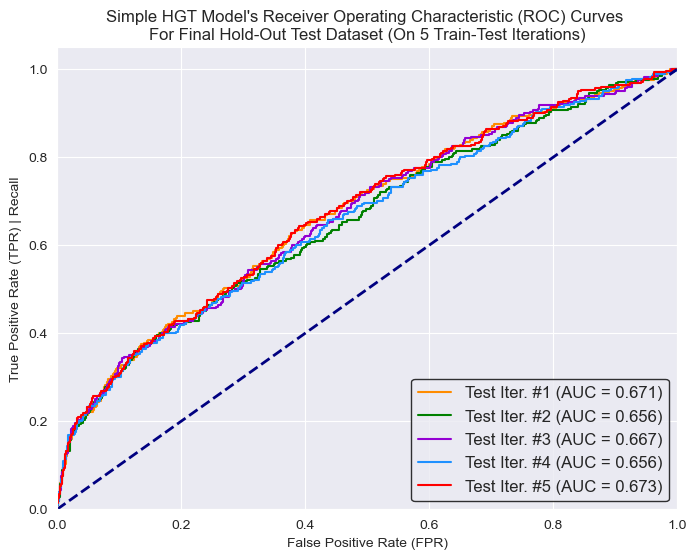

In [65]:

# Compute ROC Curve + ROC AUC For All Train-Test Iterations
    
FPR_Iteration_1, TPR_Iteration_1, Threshold_Iteration_1 = roc_curve( Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 0 ][ "Test True Class Labels" ],
                                                                     Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 0 ][ "Test Class Labels' Predicted Probabilities" ] )

FPR_Iteration_2, TPR_Iteration_2, Threshold_Iteration_2 = roc_curve( Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 1 ][ "Test True Class Labels" ],
                                                                     Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 1 ][ "Test Class Labels' Predicted Probabilities" ] )

FPR_Iteration_3, TPR_Iteration_3, Threshold_Iteration_3 = roc_curve( Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 2 ][ "Test True Class Labels" ],
                                                                     Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 2 ][ "Test Class Labels' Predicted Probabilities" ] )

FPR_Iteration_4, TPR_Iteration_4, Threshold_Iteration_4 = roc_curve( Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 3 ][ "Test True Class Labels" ],
                                                                     Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 3 ][ "Test Class Labels' Predicted Probabilities" ] )

FPR_Iteration_5, TPR_Iteration_5, Threshold_Iteration_5 = roc_curve( Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 4 ][ "Test True Class Labels" ],
                                                                     Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ 4 ][ "Test Class Labels' Predicted Probabilities" ] )
    
Test_ROC_AUC_Score_For_Train_Test_Iteration_1 = Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 0 ]["Test ROC AUC-Score"]
Test_ROC_AUC_Score_For_Train_Test_Iteration_2 = Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 1 ]["Test ROC AUC-Score"]
Test_ROC_AUC_Score_For_Train_Test_Iteration_3 = Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 2 ]["Test ROC AUC-Score"]
Test_ROC_AUC_Score_For_Train_Test_Iteration_4 = Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 3 ]["Test ROC AUC-Score"]
Test_ROC_AUC_Score_For_Train_Test_Iteration_5 = Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 4 ]["Test ROC AUC-Score"]
    

    
plt.figure( figsize = (8, 6) )
    

plt.plot( FPR_Iteration_1, TPR_Iteration_1, color = "darkorange", label = f"Test Iter. #1 (AUC = {Test_ROC_AUC_Score_For_Train_Test_Iteration_1:.3f})" )   # Plotting the ROC-Curve
plt.plot( FPR_Iteration_2, TPR_Iteration_2, color = "green", label = f"Test Iter. #2 (AUC = {Test_ROC_AUC_Score_For_Train_Test_Iteration_2:.3f})" )   # Plotting the ROC-Curve
plt.plot( FPR_Iteration_3, TPR_Iteration_3, color = "darkviolet", label = f"Test Iter. #3 (AUC = {Test_ROC_AUC_Score_For_Train_Test_Iteration_3:.3f})" )   # Plotting the ROC-Curve
plt.plot( FPR_Iteration_4, TPR_Iteration_4, color = "dodgerblue", label = f"Test Iter. #4 (AUC = {Test_ROC_AUC_Score_For_Train_Test_Iteration_4:.3f})" )   # Plotting the ROC-Curve
plt.plot( FPR_Iteration_5, TPR_Iteration_5, color = "red", label = f"Test Iter. #5 (AUC = {Test_ROC_AUC_Score_For_Train_Test_Iteration_5:.3f})" )   # Plotting the ROC-Curve
    
plt.plot( [0, 1], [0, 1], color = "navy", linewidth = 2, linestyle = "--" )   # Plotting the Threshold Limit line  ⇒  AUC_Threshold = 0.50
    

plt.xlim( [0.0, 1.0] )
    
plt.ylim( [0.0, 1.05] )
    

plt.title( f"Simple HGT Model's Receiver Operating Characteristic (ROC) Curves \nFor Final Hold-Out Test Dataset (On {Num_of_Train_Test_Iterations} Train-Test Iterations)", fontsize = 12 )
    
plt.xlabel( "False Positive Rate (FPR)", fontsize = 10 )
    
plt.ylabel( "True Positive Rate (TPR) | Recall", fontsize = 10 )
    

plt.legend( loc = "lower right", edgecolor = "k", fontsize = "large" )


plt.savefig(f"Figures/Simple HGT Model's ROC Curves For Final Hold-Out Test Dataset.png")
    
plt.show()



___

### Confusion Matrix On the Hold-Out Test Dataset For the 5 Train-Test Iterations

In [73]:

for Train_Test_Iteration_ID in range (5):

    Confusion_Matrix_For_Train_Test_Iteration = Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ][ "Test Confusion Matrix" ]

    print(f"Confusion Matrix For the Hold-Out Test Dataset, For Train-Test Iteration #{Train_Test_Iteration_ID+1}: \n\n {Confusion_Matrix_For_Train_Test_Iteration}", "\n")
    


Confusion Matrix For the Hold-Out Test Dataset, For Train-Test Iteration #1: 

 tensor([[1836,  300],
        [ 175,  105]]) 

Confusion Matrix For the Hold-Out Test Dataset, For Train-Test Iteration #2: 

 tensor([[1797,  339],
        [ 172,  108]]) 

Confusion Matrix For the Hold-Out Test Dataset, For Train-Test Iteration #3: 

 tensor([[1835,  301],
        [ 177,  103]]) 

Confusion Matrix For the Hold-Out Test Dataset, For Train-Test Iteration #4: 

 tensor([[1794,  342],
        [ 174,  106]]) 

Confusion Matrix For the Hold-Out Test Dataset, For Train-Test Iteration #5: 

 tensor([[1818,  318],
        [ 174,  106]]) 



___

In [33]:
# In the `Test_Metrics_Scores_Per_Train_Test_Iteration_dict` Dictionary --> Convert All PyTorch Tensor Values Into Scalar Float Values

# Iterate Through Each `Train_Test_Iteration_ID`

for Train_Test_Iteration_ID in range(5):  # IDs Go From 0 To 4
    
    # Get the Dictionary For the Current Train-Test Iteration
    
    Train_Test_Iteration_dict = Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ]
    

    # Iterate Through Each Key-Value Pair In the Dictionary
    
    for Metric_Name, Value in Train_Test_Iteration_dict.items():

        # Skip the Conversion If the Metric Is the Confusion Matrix
        
        if Metric_Name == "Test Confusion Matrix":
            
            continue
        
        # Check If the Value Is a PyTorch Tensor
        
        if isinstance(Value, torch.Tensor):
            
            # Convert the Tensor To a Scalar Float Value
            
            Scalar_Float_Value = Value.item()
            
        else:
            
            # If the Value Is Already a Float, Just Use It As Is
            
            Scalar_Float_Value = Value
        

        # Update the Train-Test Iteration Dictionary With the Respective Scalar Float Value
        
        Train_Test_Iteration_dict[ Metric_Name ] = Scalar_Float_Value
        

### Mean Test Brier-Score

In [46]:
# List of Test Brier-Scores In Every Train-Test Iteration

Test_Brier_Scores_Produced_In_Every_Train_Test_Iteration_list = [ Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 0 ]["Test Brier-Score"], Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 1 ]["Test Brier-Score"],
                                                                  Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 2 ]["Test Brier-Score"], Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 3 ]["Test Brier-Score"],
                                                                  Test_Metrics_Scores_Per_Train_Test_Iteration_dict[ 4 ]["Test Brier-Score"] ]

# Mean Test Brier-Score Produced By All Final Train-Test Iterations

Mean_Test_Brier_Score = np.mean( Test_Brier_Scores_Produced_In_Every_Train_Test_Iteration_list )

logging.info(f"Mean Test Brier-Score = {Mean_Test_Brier_Score}")
print(f"Mean Test Brier-Score = \033[91m\033[1m\033[4m{Mean_Test_Brier_Score}\033[0m", "\n")



# Calculate the Margin of Error of the Mean Test Brier-Score of the Train-Test Iterations

STD_of_Mean_Test_Brier_Scores_Across_Train_Test_Iterations = np.std( Test_Brier_Scores_Produced_In_Every_Train_Test_Iteration_list, ddof = 1 )   # `ddof = 1` For Sample Standard Deviation

logging.info(f"Standard Deviation of the {Num_of_Train_Test_Iterations} Test Brier-Scores of the Train-Test Iterations = {STD_of_Mean_Test_Brier_Scores_Across_Train_Test_Iterations}")
print(f"Standard Deviation of the {Num_of_Train_Test_Iterations} Test Brier-Scores of the Train-Test Iterations = \033[91m\033[1m\033[4m{STD_of_Mean_Test_Brier_Scores_Across_Train_Test_Iterations}\033[0m", "\n")

SEM = STD_of_Mean_Test_Brier_Scores_Across_Train_Test_Iterations / np.sqrt( Num_of_Train_Test_Iterations )   # Calculate the Standard Error of the Mean (SEM)

logging.info(f"Standard Error of the Mean (SEM) = {SEM}")
print(f"Standard Error of the Mean (SEM) = \033[91m\033[1m\033[4m{SEM}\033[0m", "\n")

## For a 95% Confidence Interval, the Margin of Error = SEM Multiplied By the Critical Value From the Student's t-Distribution (If the Sample Size Is Small or the Population STD Is Unknown)
##      or the Z-Distribution (For Large Sample Sizes or Known Population STF). The Critical Value For a 95% Confidence Level Is Typically 1.96 For Large Samples (Z-distribution).

alpha = 0.025

t_Distribution_Critical_Value = stats.t.ppf( q = 1 - alpha, df = Num_of_Train_Test_Iterations - 1 )   # Determine the t-Critical Value For 95% Confidence Interval/Level & 4 Degrees of Freedom / 2-Tailed ( ==> alpha * 2 = 0.5 )
                                                                                                          # `t.ppf` = Percent Point Function (Inverse of CDF — Percentiles)
Margin_of_Error = t_Distribution_Critical_Value * SEM

logging.info(f"Margin of Error of the Mean Test Brier-Score, For a 95% Confidence Interval = {Margin_of_Error}")
print(f"Margin of Error of the Mean Test Brier-Score, For a 95% Confidence Interval = \033[91m\033[1m\033[4m{Margin_of_Error}\033[0m", "\n")

logging.info(f"***** ∴ Mean Test Brier-Score To Report = {Mean_Test_Brier_Score} ± {Margin_of_Error} *****")
print(f"∴ Mean Test Brier-Score To Report = \033[91m\033[1m\033[4m{Round_To_3SF( Mean_Test_Brier_Score )}\033[0m ± \033[91m\033[1m\033[4m{Round_To_3SF( Margin_of_Error )}\033[0m", "\n")


Mean Test Brier-Score = 0.16215948903679106 

Standard Deviation of the 5 Test Brier-Scores of the Train-Test Iterations = 0.0038402286848176095 

Standard Error of the Mean (SEM) = 0.001717402477679358 

Margin of Error of the Mean Test Brier-Score, For a 95% Confidence Interval = 0.004768273702807425 

∴ Mean Test Brier-Score To Report = 0.162 ± 0.00477 



___
___

## Saving the Class (True + Predicted) Labels & the Class Labels' Probabilities 

In [77]:
# Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ] = { "Test True Class Labels" : y_Test_True_Labels,
#                                                                                                                     "Test Class Labels' Predicted Probabilities" : y_Test_Predicted_Positive_Class_Label_Probabilities,
#                                                                                                                     "Test Predicted/Classified Class Labels" : y_Test_Predicted_Class_Labels }

# Iterating Through Each `Train_Test_Iteration_ID`

for Train_Test_Iteration_ID in Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict:
    
    # Extracting the Data For the Current `Train_Test_Iteration_ID`
    
    Train_Test_Iteration_dict = Test_True_and_Predicted_Class_Labels_and_Probabilities_Per_Train_Test_Iteration_dict[ Train_Test_Iteration_ID ]
    
    
    # Creating the DataFrame For That Train-Test Iteration
    
    df = pd.DataFrame( { "Will_Be_a_Goal" : Train_Test_Iteration_dict[ "Test True Class Labels" ], 
                         "Simple HGT Model Test Class Labels' Predicted Probabilities" : Train_Test_Iteration_dict[ "Test Class Labels' Predicted Probabilities" ], 
                         "Simple HGT Model Test Predicted/Classified Class Labels" : Train_Test_Iteration_dict[ "Test Predicted/Classified Class Labels" ] } )
    

    File_Name = f"Simple HGT Model's Test Class (True + Predicted) Labels & the Test Class Labels' Probabilities From the Final Train-Test Iteration #{Train_Test_Iteration_ID+1}.csv"
    
    
    # Saving the DataFrame To a CSV File
    
    df.to_csv(File_Name, index = False)

    print(f"Predicted Hold-Out Test Data For Train-Test Iteration #{Train_Test_Iteration_ID+1} Saved To '{File_Name}'", "\n")


Predicted Hold-Out Test Data For Train-Test Iteration #1 Saved To 'Simple HGT Model's Test Class (True + Predicted) Labels & the Test Class Labels' Probabilities From the Final Train-Test Iteration #1.csv' 

Predicted Hold-Out Test Data For Train-Test Iteration #2 Saved To 'Simple HGT Model's Test Class (True + Predicted) Labels & the Test Class Labels' Probabilities From the Final Train-Test Iteration #2.csv' 

Predicted Hold-Out Test Data For Train-Test Iteration #3 Saved To 'Simple HGT Model's Test Class (True + Predicted) Labels & the Test Class Labels' Probabilities From the Final Train-Test Iteration #3.csv' 

Predicted Hold-Out Test Data For Train-Test Iteration #4 Saved To 'Simple HGT Model's Test Class (True + Predicted) Labels & the Test Class Labels' Probabilities From the Final Train-Test Iteration #4.csv' 

Predicted Hold-Out Test Data For Train-Test Iteration #5 Saved To 'Simple HGT Model's Test Class (True + Predicted) Labels & the Test Class Labels' Probabilities From t

___
___
___